# Joint analysis of paired and unpaired multiomic data with MultiVI

MultiVI is used for the joint analysis of scRNA and scATAC-seq datasets that were jointly profiled (multiomic / paired) and single-modality datasets (only scRNA or only scATAC). MultiVI uses the paired data as an anchor to align and merge the latent spaces learned from each individual modality.

Based on the [scvi-tools MultiVI tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/multimodal/MultiVI_tutorial.html) that walks through how to read multiomic data, create a joint object with paired and unpaired data, set-up and train a MultiVI model, visualize the resulting latent space, and run differential analyses. 

## this notebook is modified directly from the scvi-tools tutorial

[MultiVI tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/MultiVI_tutorial.html)

<div class="alert alert-info">
Important

MultiVI requires the datasets to use shared features. scATAC-seq datasets need to be processed to use a shared set of peaks.

</div>

In [1]:
!date

Thu May 29 10:17:36 AM EDT 2025


#### import libraries

In [2]:
import scvi
from numpy import where
import scanpy as sc
from anndata import AnnData
from anndata import concat as ad_concat
from pandas import read_csv, concat, DataFrame
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import torch
from seaborn import lineplot
from sklearn.metrics import silhouette_score
from numpy import arange, mean

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

scvi.settings.seed = 42

%matplotlib inline
# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Seed set to 42


#### set notebook variables

In [3]:
# variables and constants
project = 'aging_phase2'
DEBUG = True
MIN_CELL_PERCENT = 0.005
MAX_MITO_PERCENT = 10
TESTING = False
testing_cell_size = 5000
DETECT_HV_FEATURES = True
FILTER_HV_FEATURES = True
TOP_FEATURES_PERCENT = 0.15
leiden_res = 1.0
RUN_TRAINING = True
BATCH_SIZE = 4000
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# directories
wrk_dir = '/labshare/raph/datasets/adrd_neuro/brain_aging/phase2'
quants_dir = f'{wrk_dir}/quants'
models_dir = f'{wrk_dir}/models'
figures_dir = f'{wrk_dir}/figures'
sc.settings.figdir = f'{figures_dir}/'
public_dir = f'{wrk_dir}/public'

# in files
arc_file = f'{quants_dir}/{project}_ARC.raw.h5ad'
arc_scrublet_file = f'{quants_dir}/{project}_ARC.scrublet_scores.csv'
gex_file = f'{quants_dir}/{project}_GEX.raw.h5ad'
gex_scrublet_file = f'{quants_dir}/{project}_GEX.scrublet_scores.csv'
atac_file = f'{quants_dir}/{project}_ATAC.raw.h5ad'
curated_file = f'{quants_dir}/{project}.multivi.curated_final.h5ad'

# out files
# raw_anndata_file =f'{quants_dir}/{project}.raw.h5ad'
# out_h5ad_file = f'{quants_dir}/{project}.multivi.h5ad'
# trained_model_path = f'{models_dir}/{project}_trained_multivi'
# mvi_normalized_exp_file = f'{quants_dir}/{project}.multivi_norm_exp.parquet'
# mvi_peak_est_file = f'{quants_dir}/{project}.multivi_peak_est.parquet'
# mvi_df_results_file = f'{quants_dir}/{project}.multivi_diff_exp_by_cluster.parquet'

if DEBUG:
    print(f'{arc_file=}')
    print(f'{arc_scrublet_file=}')
    print(f'{gex_file=}')
    print(f'{gex_scrublet_file=}')
    print(f'{atac_file=}')
    print(f'{curated_file=}')
    print(f'{device=}')

arc_file='/labshare/raph/datasets/adrd_neuro/brain_aging/phase2/quants/aging_phase2_ARC.raw.h5ad'
arc_scrublet_file='/labshare/raph/datasets/adrd_neuro/brain_aging/phase2/quants/aging_phase2_ARC.scrublet_scores.csv'
gex_file='/labshare/raph/datasets/adrd_neuro/brain_aging/phase2/quants/aging_phase2_GEX.raw.h5ad'
gex_scrublet_file='/labshare/raph/datasets/adrd_neuro/brain_aging/phase2/quants/aging_phase2_GEX.scrublet_scores.csv'
atac_file='/labshare/raph/datasets/adrd_neuro/brain_aging/phase2/quants/aging_phase2_ATAC.raw.h5ad'
curated_file='/labshare/raph/datasets/adrd_neuro/brain_aging/phase2/quants/aging_phase2.multivi.curated_final.h5ad'
device='cuda'


#### functions

In [4]:
def peek_anndata(adata: AnnData, message: str=None, verbose: bool=False):
    if not message is None and len(message) > 0:
        print(message)
    print(adata)
    if verbose:
        display(adata.obs.head())
        display(adata.var.head())

def heatmap_compare(adata: AnnData, set1: str, set2: str):
    this_df = (
        adata.obs.groupby([set1, set2])
        .size()
        .unstack(fill_value=0)
    )
    norm_df = this_df/this_df.sum(axis=0)

    with rc_context({'figure.figsize': (12, 12), 'figure.dpi': 100}):
        plt.style.use('seaborn-v0_8-bright')
        _ = plt.pcolor(norm_df, edgecolor='black')
        _ = plt.xticks(arange(0.5, len(this_df.columns), 1), this_df.columns, rotation=90)
        _ = plt.yticks(arange(0.5, len(this_df.index), 1), this_df.index)
        plt.xlabel(set2)
        plt.ylabel(set1)
        plt.show()

## load data

### load the previously full processed and curated multiVI anndata

In [5]:
%%time
adata_final =  sc.read_h5ad(curated_file)
peek_anndata(adata_final, 'previous fully processed anndata', DEBUG)

previous fully processed anndata
AnnData object with n_obs × n_vars = 229074 × 226404
    obs: 'sample_id', 'donor_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'Study', 'Study_type', 'modality', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_indices', '_scvi_batch', '_scvi_labels', 'leiden_MultiVI', 'Cell_type', 'RefCluster', 'curated_type', 'cluster_name'
    var: 'ID', 'modality', 'chr', 'start', 'end', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Cell_type_colors', 'Study_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cluster_name_colors', 'curated_type_colors', 'hvg', 'leiden', 'leiden_MultiVI_colors', 'neighbors', 'phase1_celltype_colors', 'phase1_cluster_colors', 'sample_id_colors', 'umap'
  

sample_id    donor_id           geno_IID     sex  \
AAACAGCCAACCCTCC_paired  Aging120  NHBCC-1512       4256126241_A  Female   
AAACAGCCAAGGATTA_paired  Aging120  NHBCC-1512       4256126241_A  Female   
AAACAGCCAAGTCGCT_paired  Aging121  NHBCC-1890  4572348740_R01C02    Male   
AAACAGCCAATAACCT_paired  Aging120  NHBCC-1512       4256126241_A  Female   
AAACAGCCAATCCCTT_paired  Aging120  NHBCC-1512       4256126241_A  Female   

                          ancestry   age gex_pool atac_pool   pmi    ph  ...  \
AAACAGCCAACCCTCC_paired  Caucasian  30.0      non       non   9.5  6.92  ...   
AAACAGCCAAGGATTA_paired  Caucasian  30.0      non       non   9.5  6.92  ...   
AAACAGCCAAGTCGCT_paired  Caucasian  42.1      non       non  24.5  6.34  ...   
AAACAGCCAATAACCT_paired  Caucasian  30.0      non       non   9.5  6.92  ...   
AAACAGCCAATCCCTT_paired  Caucasian  30.0      non       non   9.5  6.92  ...   

                         total_counts_mt  pct_counts_mt  _indices _scvi_batch  \
AAACAGCCAACCCTCC_paired              0.0       0.000000         0           2   
AAACAGCCAAGGATTA_paired             11.0       0.016451         1           2   
AAACAGCCAAGTCGCT_paired              2.0       0.016244         2           2   
AAACAGCCAATAACCT_paired              3.0       0.004038         3           2   
AAACAGCCAATCCCTT_paired              1.0       0.010535         4           2   

                        _scvi_labels leiden_MultiVI          Cell_type  \
AAACAGCCAACCCTCC_paired            0              0  Oligodendrocyte-1   
AAACAGCCAAGGATTA_paired            0              8          ExN FEZF2   
AAACAGCCAAGTCGCT_paired            0              0  Oligodendrocyte-1   
AAACAGCCAATAACCT_paired            0             14    ExN RORB THEMIS   
AAACAGCCAATCCCTT_paired            0              0  Oligodendrocyte-1   

                        RefCluster  curated_type  cluster_name  
AAACAGCCAACCCTCC_paired          1            OD          OD-0  
AAACAGCCAAGGATTA_paired          9           ExN         ExN-8  
AAACAGCCAAGTCGCT_paired          1            OD          OD-0  
AAACAGCCAATAACCT_paired         11           ExN        ExN-14  
AAACAGCCAATCCCTT_paired          1            OD          OD-0  

[5 rows x 30 columns]

ID         modality    chr     start       end  \
AL391261.2  ENSG00000258847  Gene Expression  chr14  66004522  66004523   
FUT8        ENSG00000033170  Gene Expression  chr14  65410591  65413008   
AL139022.1  ENSG00000259118  Gene Expression  chr14  65082033  65089918   
MAX         ENSG00000125952  Gene Expression  chr14  65102338  65102690   
FNTB        ENSG00000257365  Gene Expression  chr14  64986894  64986895   

               mt  n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
AL391261.2  False               4033     0.020360              98.311471   
FUT8        False              95446     1.588444              60.038853   
AL139022.1  False               6749     0.031598              97.174342   
MAX         False              53615     0.437937              77.552575   
FNTB        False              36625     0.233007              84.665916   

            total_counts  n_cells  highly_variable  highly_variable_rank  \
AL391261.2        4863.0     4033            False                   NaN   
FUT8            379395.0    95321             True                3272.0   
AL139022.1        7547.0     6749            False                   NaN   
MAX             104600.0    53559             True                3369.0   
FNTB             55653.0    36612             True                7499.0   

               means  variances  variances_norm  highly_variable_nbatches  
AL391261.2  0.020409   0.029460        0.703549                         0  
FUT8        1.591611  10.011322        1.013689                         1  
AL139022.1  0.031673   0.038484        0.585346                         0  
MAX         0.438727   1.178464        0.994550                         1  
FNTB        0.233500   0.448144        0.828779                         1

CPU times: user 3.2 s, sys: 14.4 s, total: 17.6 s
Wall time: 41.3 s


#### visualize previous data's projections

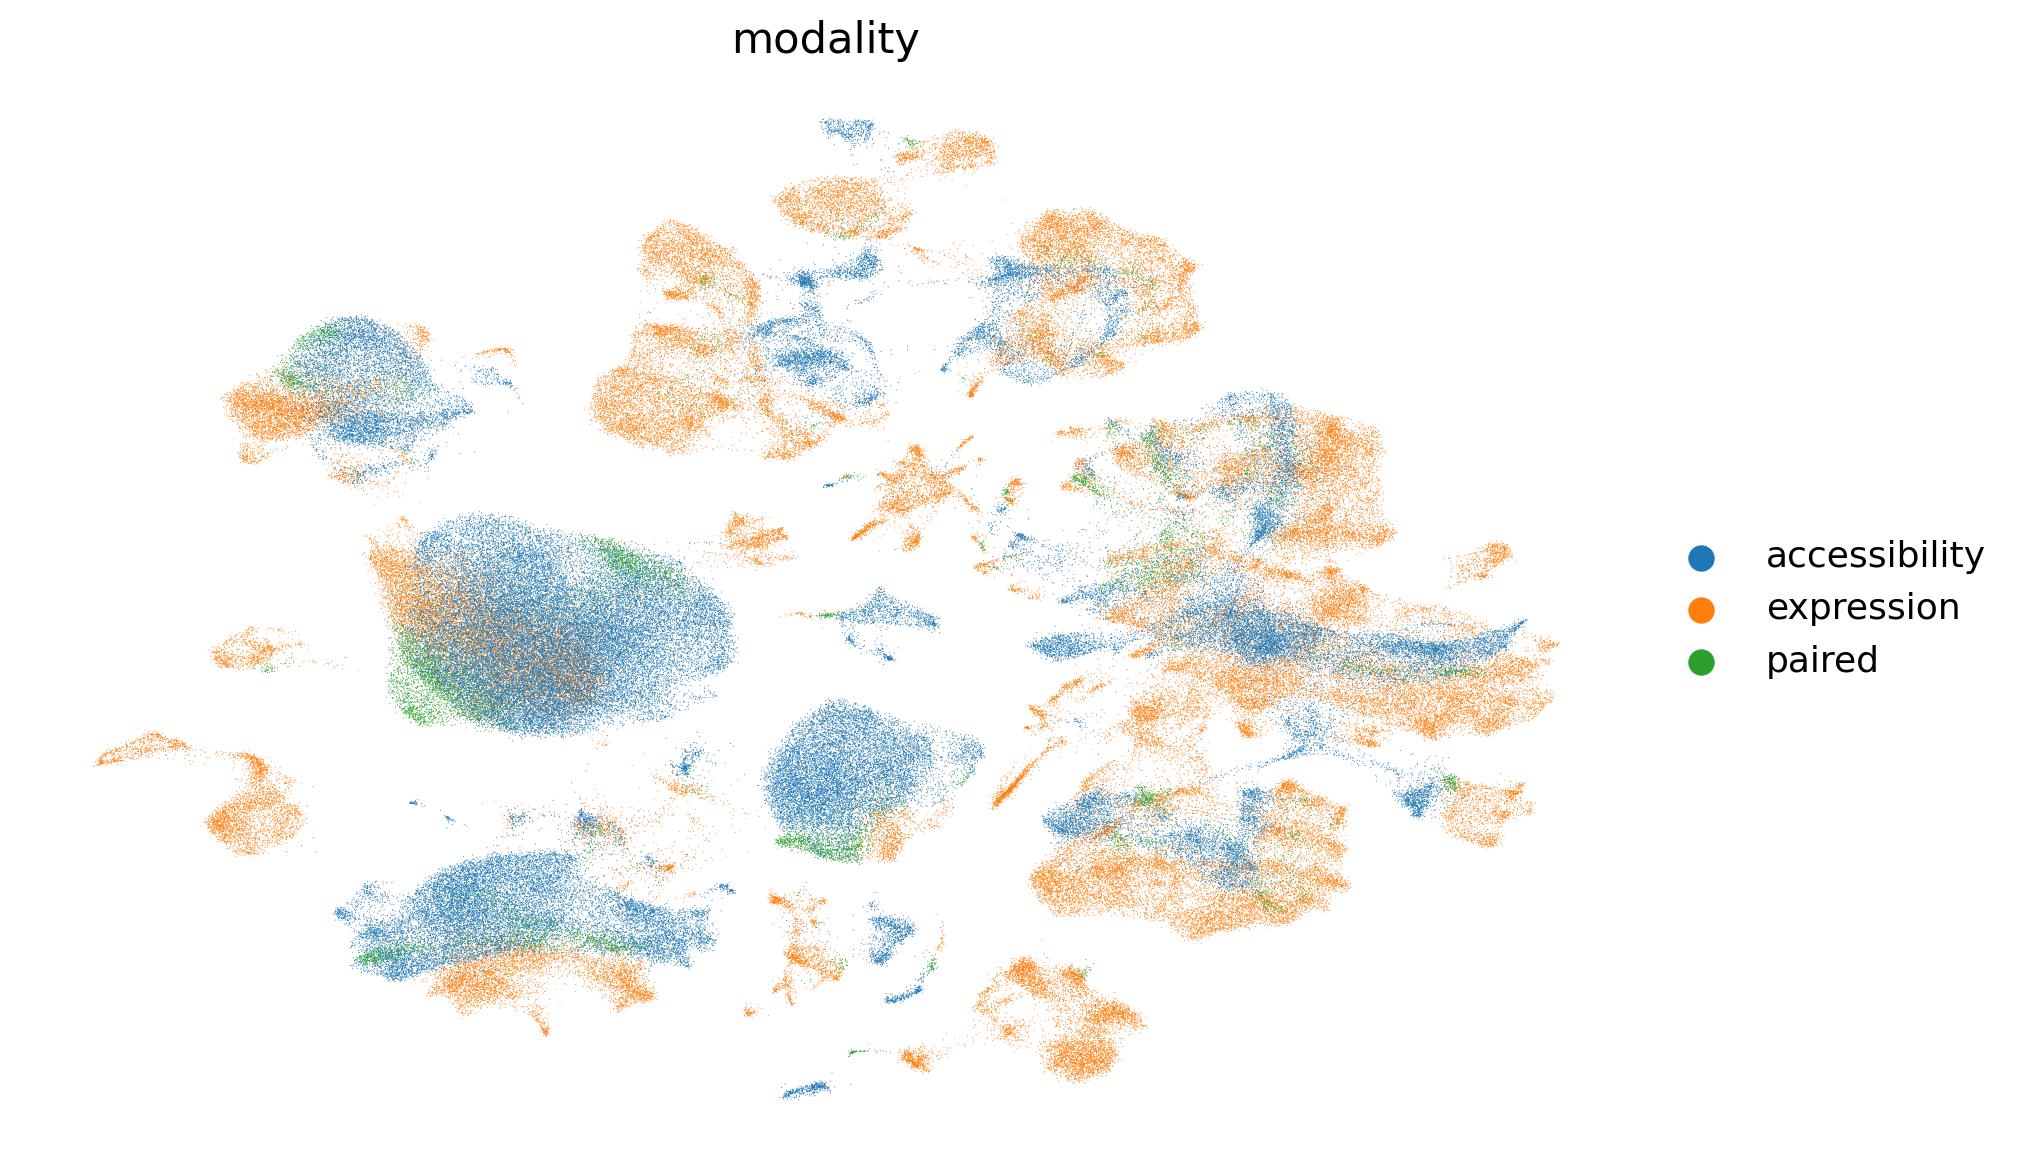

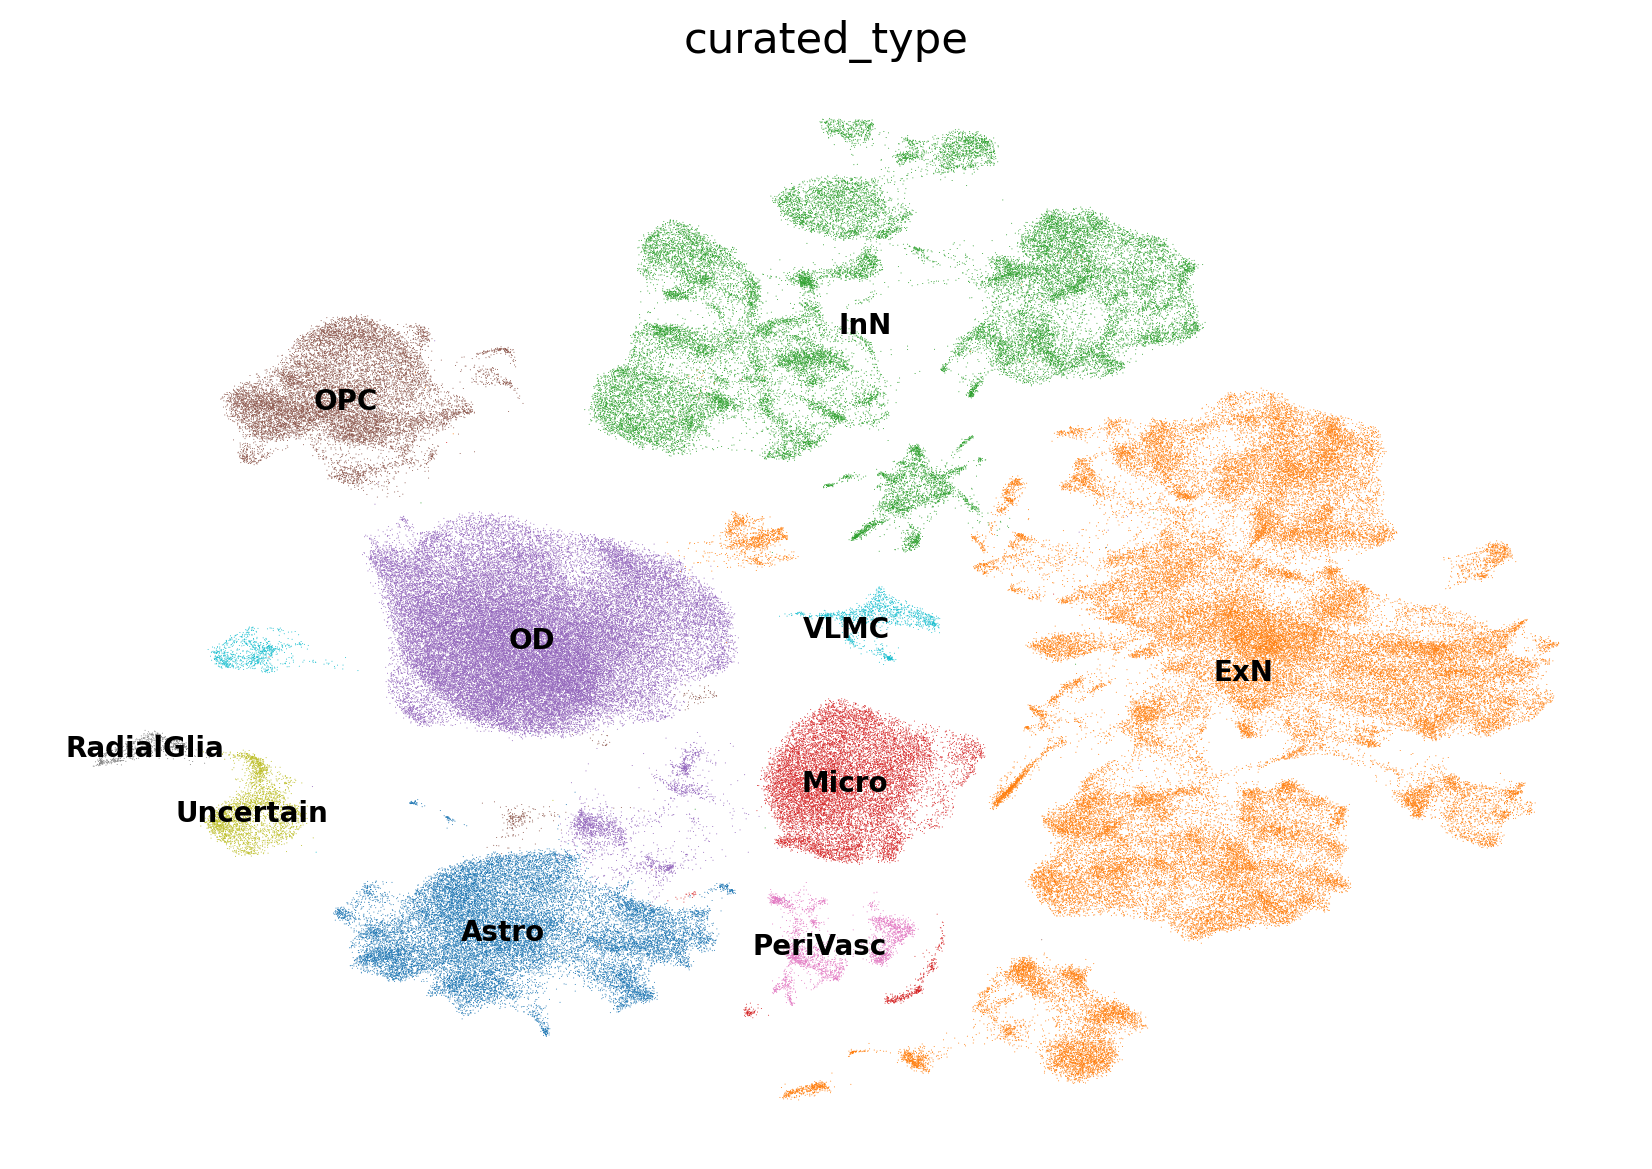

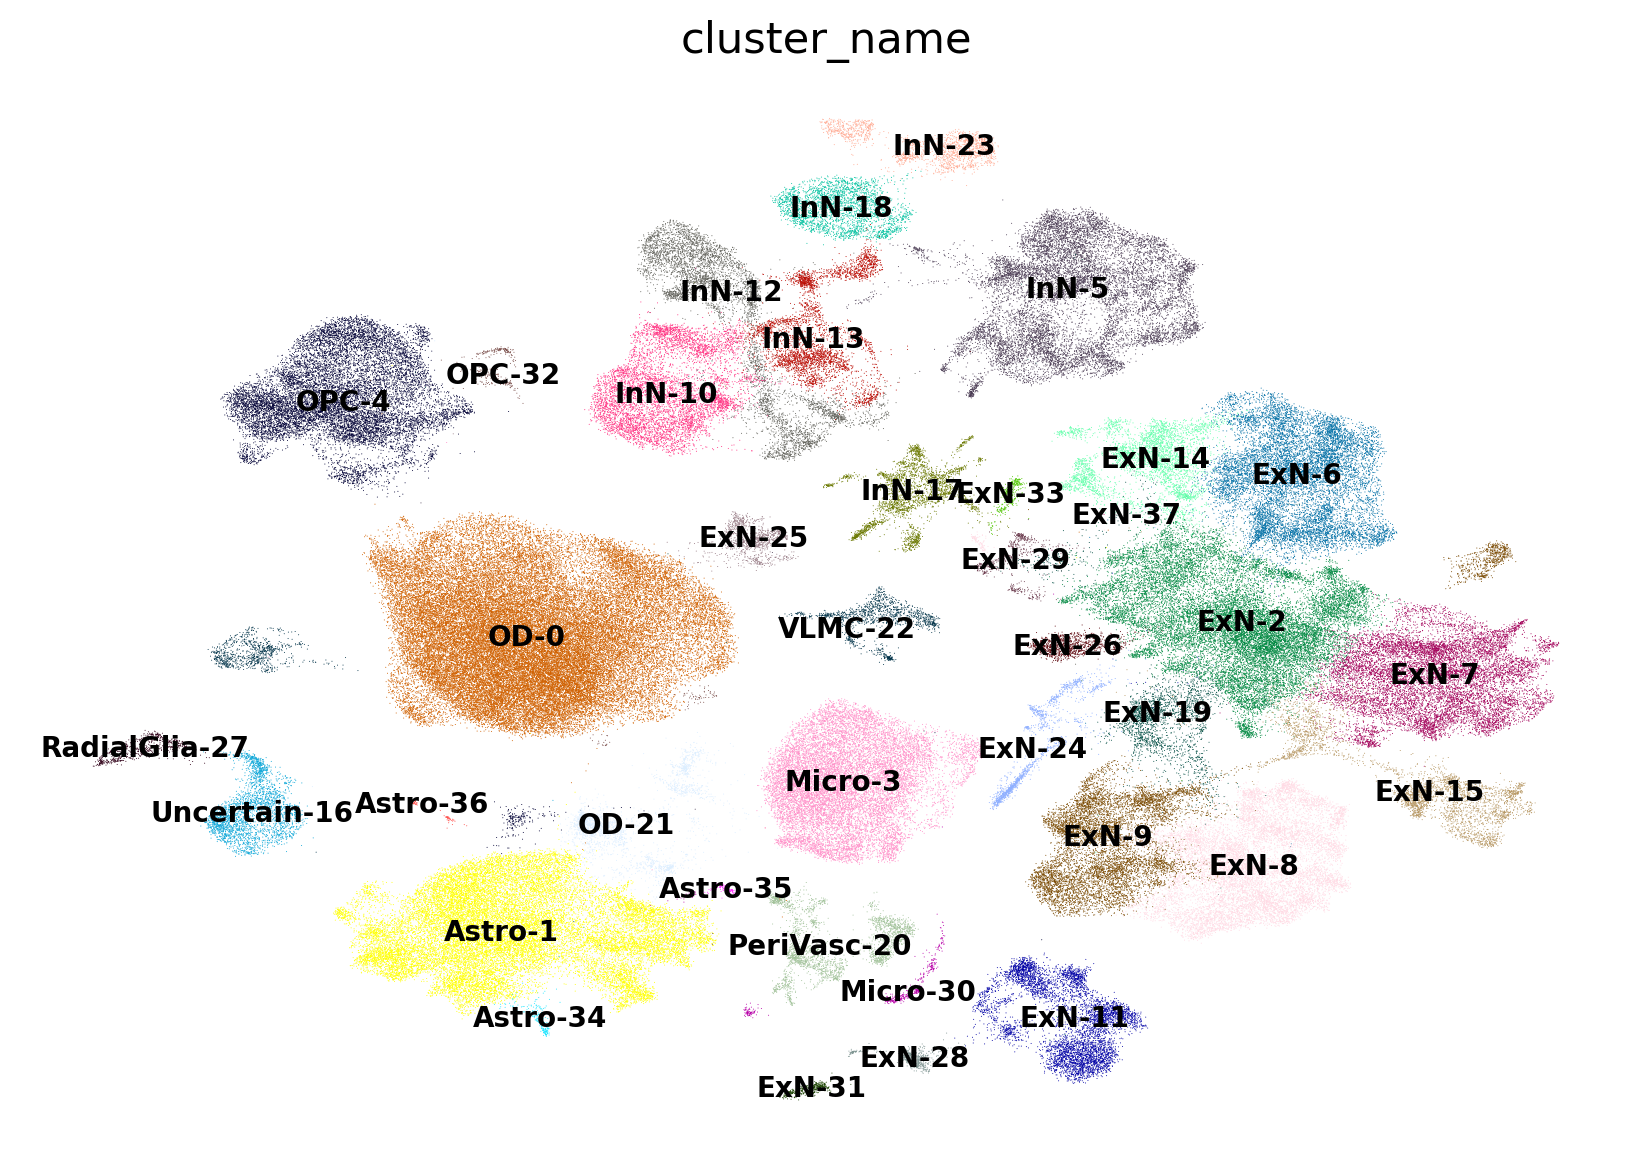

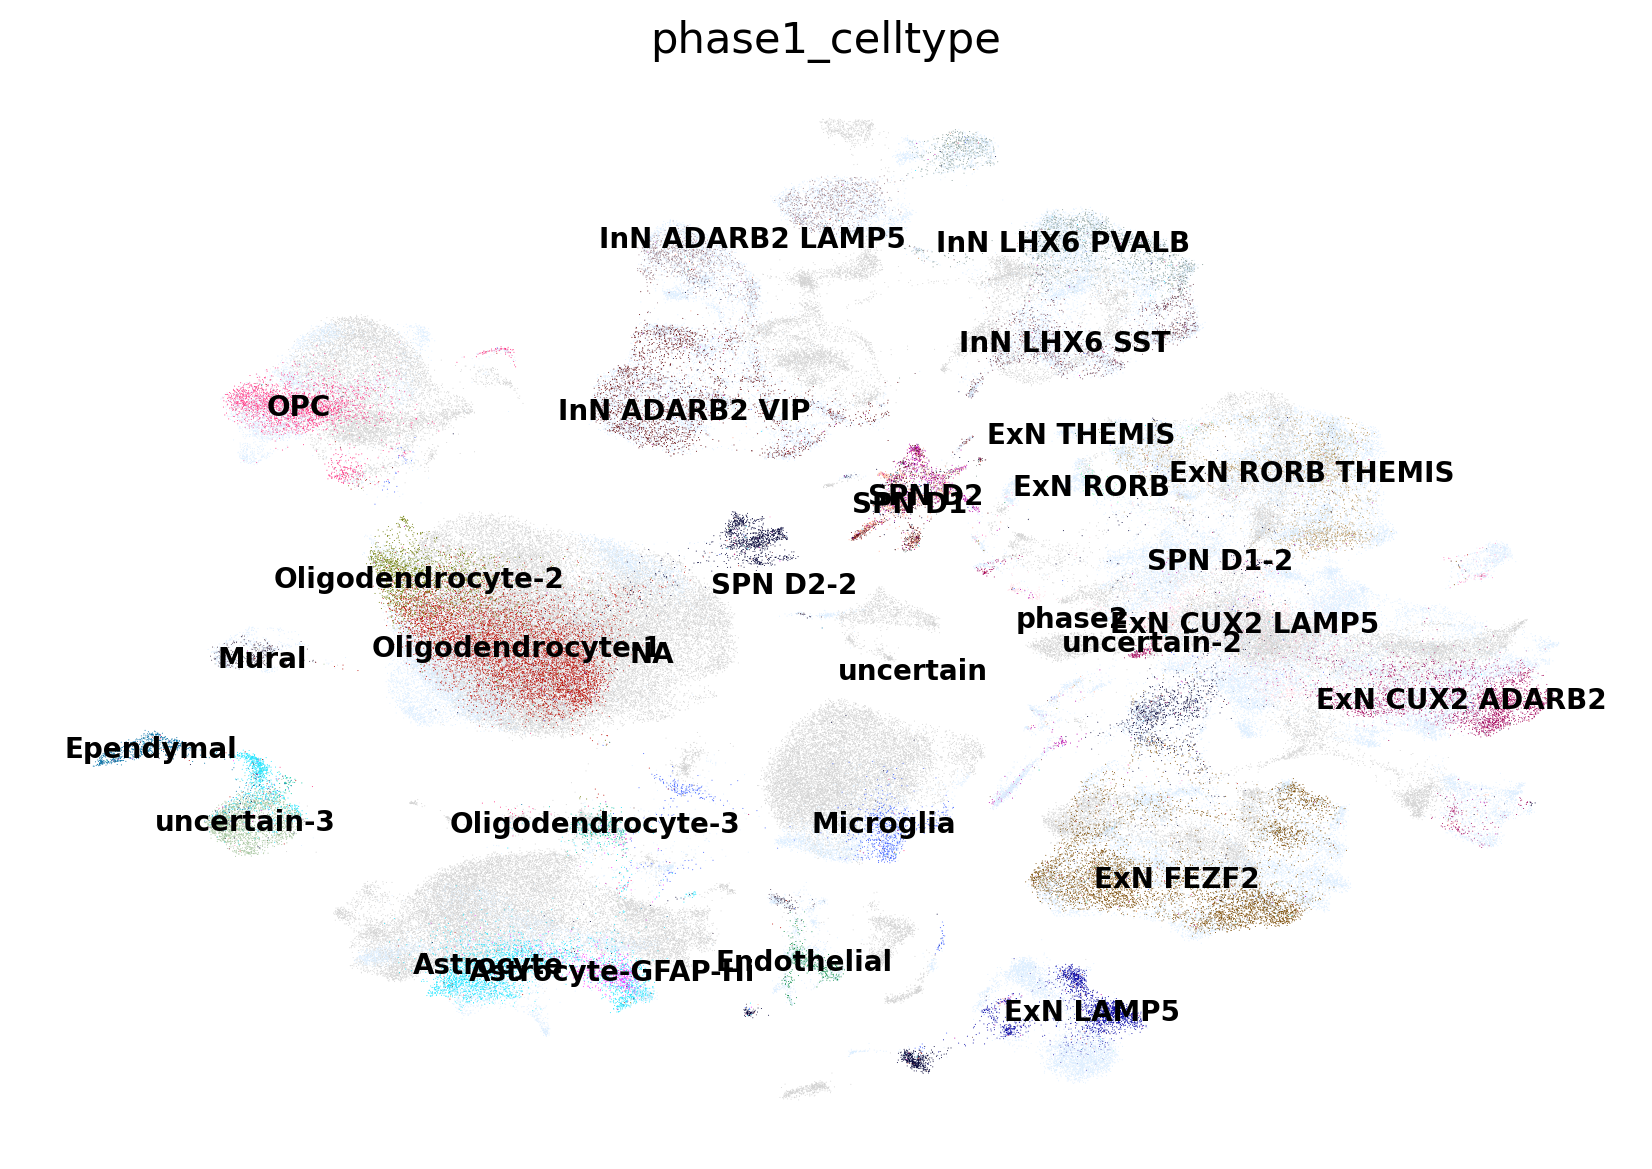

In [6]:
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': 100}):
    plt.style.use('seaborn-v0_8-talk')
    sc.pl.umap(adata_final, color=['modality'], frameon=False)
    sc.pl.umap(adata_final, color=['curated_type'], frameon=False, legend_loc='on data')
    sc.pl.umap(adata_final, color=['cluster_name'], frameon=False, legend_loc='on data')
    sc.pl.umap(adata_final, color=['phase1_celltype'], frameon=False, legend_loc='on data')    

#### are any of the cluster primarily ATAC 

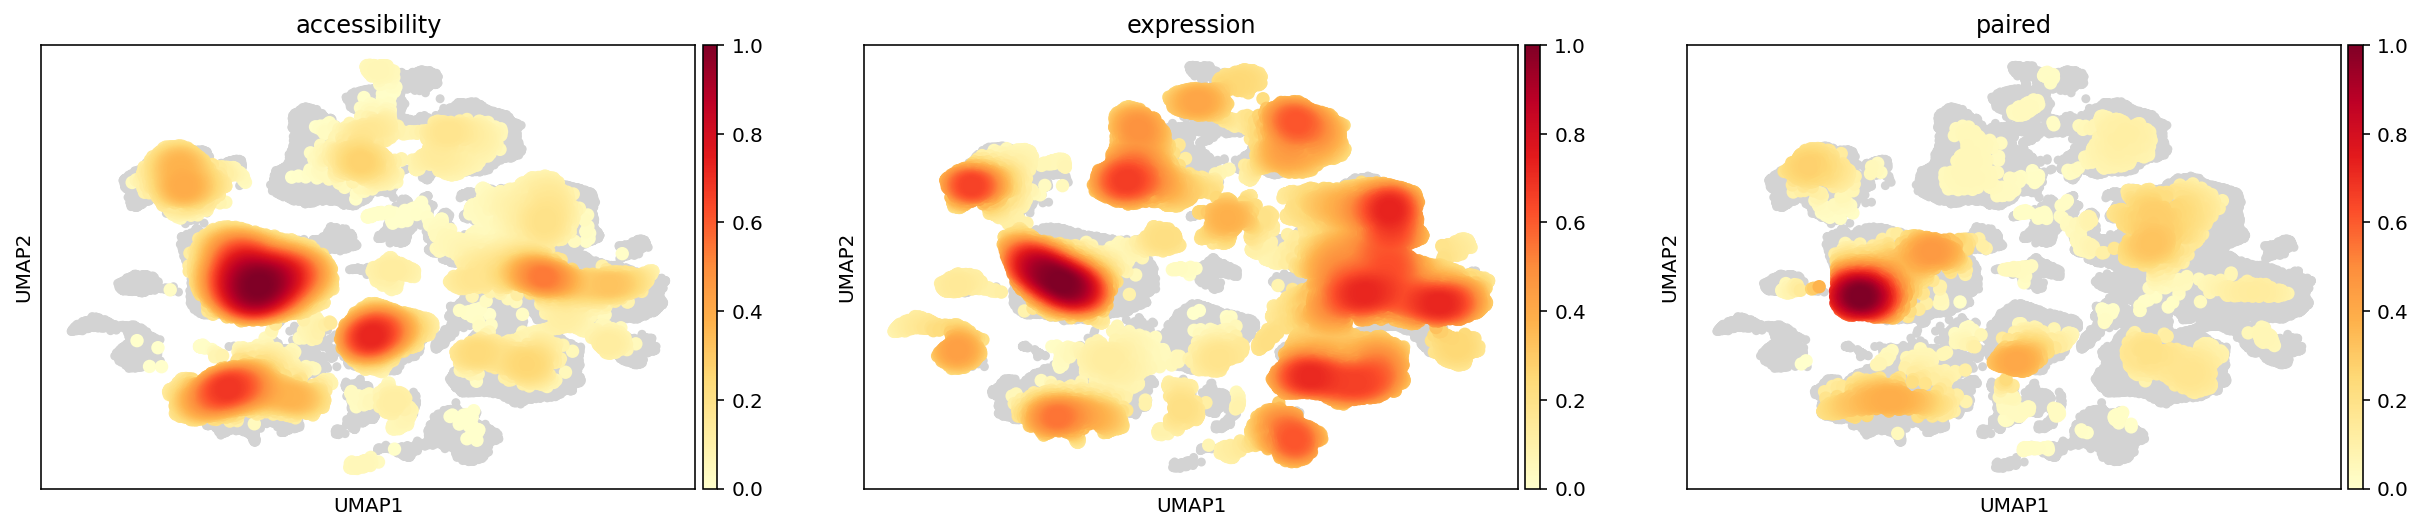

CPU times: user 4min 18s, sys: 1.35 s, total: 4min 19s
Wall time: 3min 55s


In [7]:
%%time
sc.tl.embedding_density(adata_final, basis='umap', groupby='modality')
sc.pl.embedding_density(adata_final, basis='umap', key='umap_density_modality', ncols=3)

#### what percentage of cells areaccessibility

In [8]:
modality_counts = adata_final.obs.modality.value_counts()
percentages = (modality_counts / modality_counts.sum()) * 100
modality_counts = modality_counts.to_frame()
modality_counts['percentages'] = percentages.values
display(modality_counts)
percentage_accessibility = modality_counts.loc['accessibility'].percentages
print(percentage_accessibility)

count  percentages
modality                          
expression     110638    48.297930
accessibility   99977    43.643975
paired          18459     8.058095

43.6439753092887


In [9]:
prev_atac_clusters = []
for cluster in adata_final.obs.cluster_name.unique():
    this_cluster = adata_final.obs.loc[adata_final.obs.cluster_name == cluster]
    cluster_cnts = this_cluster.modality.value_counts()
    percentages = (cluster_cnts / cluster_cnts.sum()) * 100
    if percentages.accessibility > 90:
        print(f'{cluster=}')
        prev_atac_clusters.append(cluster)
        cluster_cnts = cluster_cnts.to_frame()
        cluster_cnts['percentages'] = percentages.values
        display(cluster_cnts)
print(prev_atac_clusters)

cluster='InN-13'


count  percentages
modality                         
accessibility   3890    99.820375
expression         6     0.153965
paired             1     0.025661

cluster='Astro-35'


count  percentages
modality                         
accessibility    110    99.099099
expression         1     0.900901
paired             0     0.000000

cluster='ExN-26'


count  percentages
modality                         
accessibility   1039    99.903846
expression         1     0.096154
paired             0     0.000000

cluster='ExN-31'


count  percentages
modality                         
accessibility    397        100.0
expression         0          0.0
paired             0          0.0

cluster='Astro-36'


count  percentages
modality                         
accessibility     75        100.0
expression         0          0.0
paired             0          0.0

cluster='ExN-37'


count  percentages
modality                         
accessibility      1        100.0
expression         0          0.0
paired             0          0.0

['InN-13', 'Astro-35', 'ExN-26', 'ExN-31', 'Astro-36', 'ExN-37']


View of AnnData object with n_obs × n_vars = 5521 × 226404
    obs: 'sample_id', 'donor_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'Study', 'Study_type', 'modality', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_indices', '_scvi_batch', '_scvi_labels', 'leiden_MultiVI', 'Cell_type', 'RefCluster', 'curated_type', 'cluster_name', 'umap_density_modality'
    var: 'ID', 'modality', 'chr', 'start', 'end', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Cell_type_colors', 'Study_colors', '_scvi_manager_uuid', '_scvi_uuid', 'curated_type_colors', 'hvg', 'leiden', 'neighbors', 'phase1_celltype_colors', 'phase1_cluster_colors', 'sample_id_colors', 'umap', 'umap_density_modality_params'
    obsm: 'MultiVI_l

cluster_name
InN-13      3897
ExN-26      1040
ExN-31       397
Astro-35     111
Astro-36      75
ExN-37         1
Name: count, dtype: int64

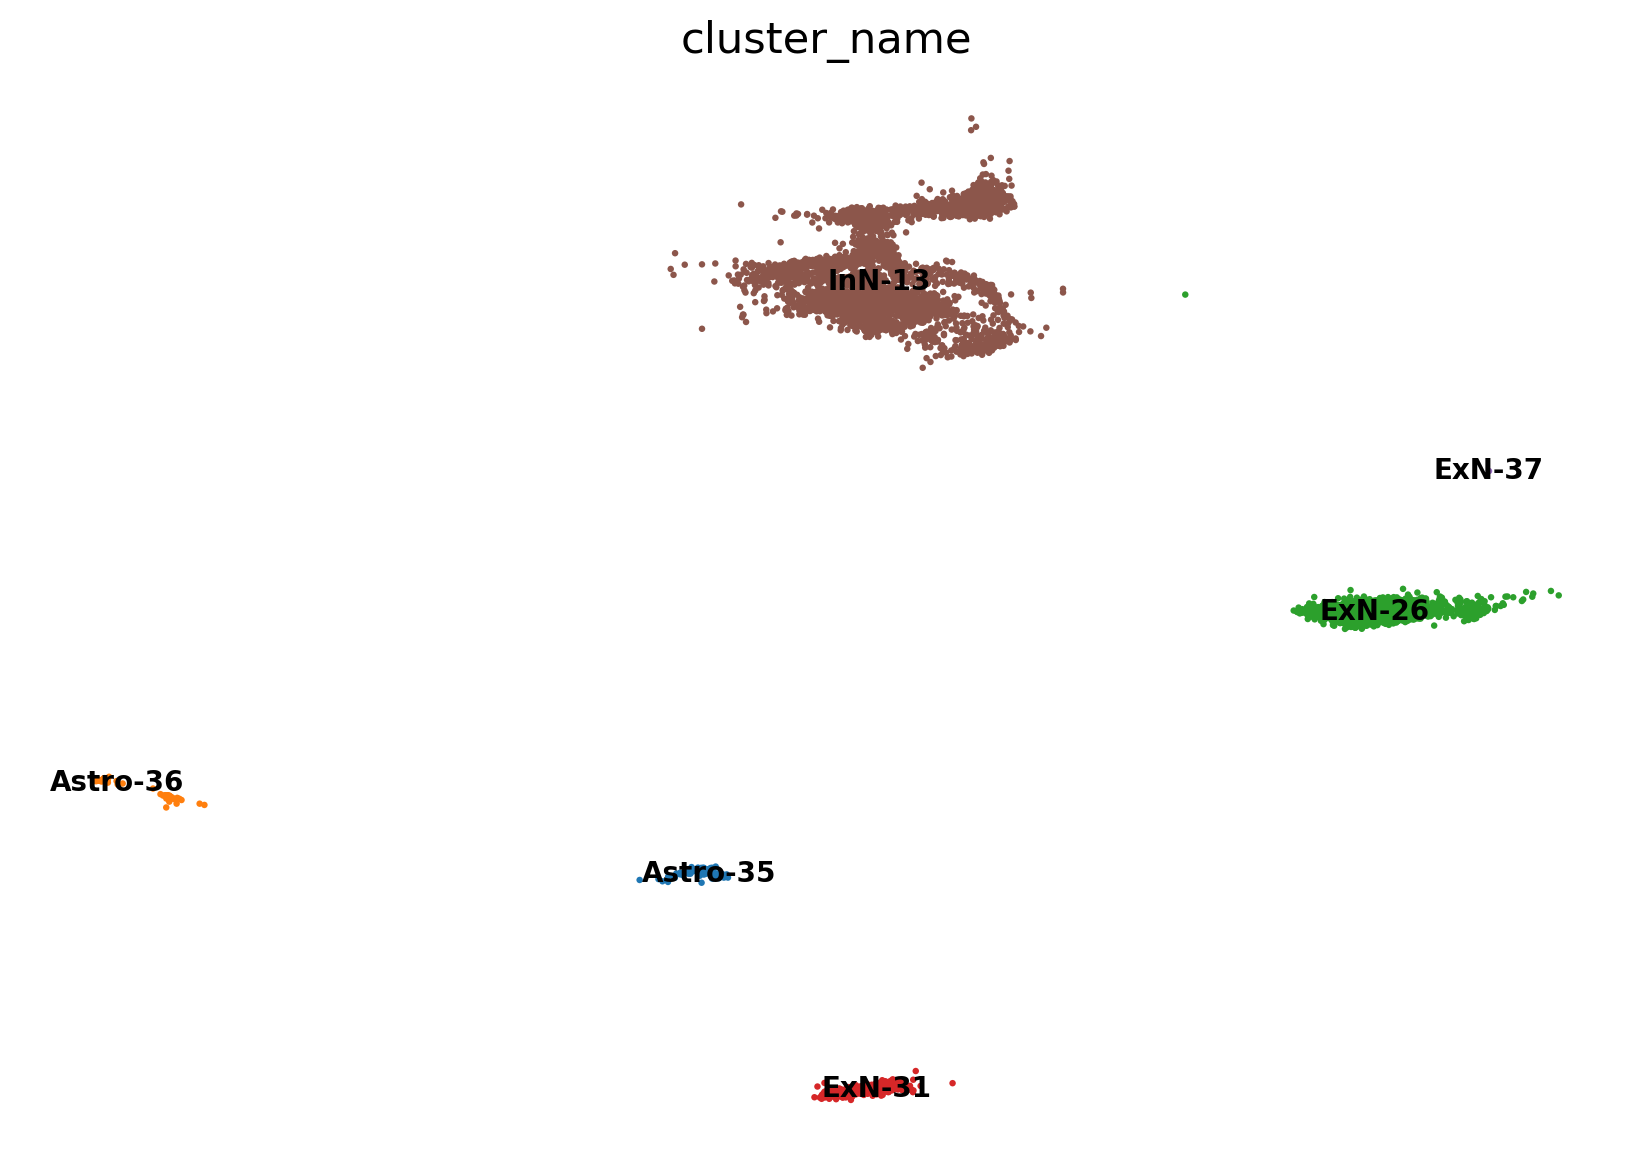

In [10]:
if len(prev_atac_clusters) > 0:
    adata_final_sub = adata_final[adata_final.obs.cluster_name.isin(prev_atac_clusters)]
    print(adata_final_sub)
    display(adata_final_sub.obs.cluster_name.value_counts())
    with rc_context({'figure.figsize': (9, 9), 'figure.dpi': 100}):
        plt.style.use('seaborn-v0_8-talk')
        sc.pl.umap(adata_final_sub, color=['cluster_name'], frameon=False, legend_loc='on data')

### load ARC data

In [11]:
%%time
arc_data = sc.read_h5ad(arc_file)
# discovery data from Duffy
arc_data.obs['Study'] = 'LNG'
arc_data.obs['Study_type'] = 'discovery'
print(arc_data)
if DEBUG:
    display(arc_data.obs.head())

AnnData object with n_obs × n_vars = 18671 × 258031
    obs: 'sample_id', 'donor_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'Study', 'Study_type'
    var: 'ID', 'modality', 'chr', 'start', 'end'


sample_id    donor_id           geno_IID     sex   ancestry  \
barcode                                                                        
AAACAGCCAACCCTCC  Aging120  NHBCC-1512       4256126241_A  Female  Caucasian   
AAACAGCCAAGGATTA  Aging120  NHBCC-1512       4256126241_A  Female  Caucasian   
AAACAGCCAAGTCGCT  Aging121  NHBCC-1890  4572348740_R01C02    Male  Caucasian   
AAACAGCCAATAACCT  Aging120  NHBCC-1512       4256126241_A  Female  Caucasian   
AAACAGCCAATCCCTT  Aging120  NHBCC-1512       4256126241_A  Female  Caucasian   

                   age  gex_pool  atac_pool   pmi    ph  smoker   bmi  rin  \
barcode                                                                      
AAACAGCCAACCCTCC  30.0       NaN        NaN   9.5  6.92     0.0  21.9  6.9   
AAACAGCCAAGGATTA  30.0       NaN        NaN   9.5  6.92     0.0  21.9  6.9   
AAACAGCCAAGTCGCT  42.1       NaN        NaN  24.5  6.34     0.0  28.9  5.9   
AAACAGCCAATAACCT  30.0       NaN        NaN   9.5  6.92     0.0  21.9  6.9   
AAACAGCCAATCCCTT  30.0       NaN        NaN   9.5  6.92     0.0  21.9  6.9   

                 phase1_cluster phase1_celltype Study Study_type  
barcode                                                           
AAACAGCCAACCCTCC             NA              NA   LNG  discovery  
AAACAGCCAAGGATTA             NA              NA   LNG  discovery  
AAACAGCCAAGTCGCT             NA              NA   LNG  discovery  
AAACAGCCAATAACCT             NA              NA   LNG  discovery  
AAACAGCCAATCCCTT             NA              NA   LNG  discovery

CPU times: user 726 ms, sys: 1.45 s, total: 2.17 s
Wall time: 4.95 s


In [12]:
arc_srublet_df = read_csv(arc_scrublet_file, index_col=0)
print(f'shape of ARC scrublet df {arc_srublet_df.shape}')
if DEBUG:
    display(arc_srublet_df.predicted_doublet.value_counts())    
    display(arc_srublet_df.sample(5))

shape of ARC scrublet df (18671, 17)


predicted_doublet
False    18459
True       212
Name: count, dtype: int64

sample_id    donor_id           geno_IID     sex  \
barcode                                                             
ATGTCCACAATTGAAG  Aging119  NHBCC-1390  4463344122_R01C02  Female   
CGCCTCATCCTCATCA  Aging119  NHBCC-1390  4463344122_R01C02  Female   
ATCGAGGCAACTGGGA  Aging120  NHBCC-1512       4256126241_A  Female   
TATTCGTTCCTCACAC  Aging120  NHBCC-1512       4256126241_A  Female   
CAGCTCAAGACTTATG  Aging121  NHBCC-1890  4572348740_R01C02    Male   

                          ancestry   age  gex_pool  atac_pool    pmi    ph  \
barcode                                                                      
ATGTCCACAATTGAAG  African American  42.7       NaN        NaN   8.17  6.34   
CGCCTCATCCTCATCA  African American  42.7       NaN        NaN   8.17  6.34   
ATCGAGGCAACTGGGA         Caucasian  30.0       NaN        NaN   9.50  6.92   
TATTCGTTCCTCACAC         Caucasian  30.0       NaN        NaN   9.50  6.92   
CAGCTCAAGACTTATG         Caucasian  42.1       NaN        NaN  24.50  6.34   

                  smoker   bmi  rin  phase1_cluster  phase1_celltype  \
barcode                                                                
ATGTCCACAATTGAAG     1.0  47.9  8.4             NaN              NaN   
CGCCTCATCCTCATCA     1.0  47.9  8.4             NaN              NaN   
ATCGAGGCAACTGGGA     0.0  21.9  6.9             NaN              NaN   
TATTCGTTCCTCACAC     0.0  21.9  6.9             NaN              NaN   
CAGCTCAAGACTTATG     0.0  28.9  5.9             NaN              NaN   

                  doublet_score  predicted_doublet  
barcode                                             
ATGTCCACAATTGAAG       0.054067              False  
CGCCTCATCCTCATCA       0.082738              False  
ATCGAGGCAACTGGGA       0.128226              False  
TATTCGTTCCTCACAC       0.156955              False  
CAGCTCAAGACTTATG       0.042449              False

### load GEX data

In [13]:
%%time
gex_data = sc.read_h5ad(gex_file)
print(gex_data)
# filter non-demultiplex cells
gex_data = gex_data[~gex_data.obs['donor_id'].isna()]
# discovery data from Duffy
gex_data.obs['Study'] = 'LNG'
gex_data.obs['Study_type'] = 'discovery'
print(gex_data)
if DEBUG:
    display(gex_data.obs.sample(5))
    display(gex_data.var.sample(5))    

AnnData object with n_obs × n_vars = 126718 × 36601
    obs: 'sample_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'donor_id'
AnnData object with n_obs × n_vars = 112022 × 36601
    obs: 'sample_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'donor_id', 'Study', 'Study_type'


sample_id             geno_IID     sex          ancestry  \
GTCATCCCATTAAGCC-1  Aging096         4040296068_A    Male  African American   
TTCATGTGTGCAACGA-1  Aging108         4031091062_A  Female         Caucasian   
GGAATGGGTCCTATAG-1  Aging112  204321360038_R01C01    Male  African American   
CCTATCGCAATCACGT-1  Aging081         4256126251_A  Female  African American   
GAACGTTTCAGAACCT-1  Aging134     4031091029_A_dup  Female  African American   

                     age  gex_pool  atac_pool   pmi    ph  smoker   bmi  rin  \
GTCATCCCATTAAGCC-1  27.2       4.0        1.0  14.0  6.37     0.0  32.9  NaN   
TTCATGTGTGCAACGA-1  83.6       4.0        1.0  33.5  6.78     0.0  25.3  NaN   
GGAATGGGTCCTATAG-1  26.1       4.0        1.0  35.0  6.48     1.0  41.2  NaN   
CCTATCGCAATCACGT-1  21.5       4.0        1.0  25.0  6.59     0.0  48.7  NaN   
GAACGTTTCAGAACCT-1  71.8       6.0        6.0  25.0  6.47     1.0  33.3  6.6   

                   phase1_cluster  phase1_celltype    donor_id Study  \
GTCATCCCATTAAGCC-1             13      uncertain-3  NHBCC-1604   LNG   
TTCATGTGTGCAACGA-1             11  ExN RORB THEMIS  NHBCC-1669   LNG   
GGAATGGGTCCTATAG-1             12   InN LHX6 PVALB  NHBCC-2628   LNG   
CCTATCGCAATCACGT-1             13      uncertain-3  NHBCC-1187   LNG   
GAACGTTTCAGAACCT-1             NA               NA  NHBCC-1615   LNG   

                   Study_type  
GTCATCCCATTAAGCC-1  discovery  
TTCATGTGTGCAACGA-1  discovery  
GGAATGGGTCCTATAG-1  discovery  
CCTATCGCAATCACGT-1  discovery  
GAACGTTTCAGAACCT-1  discovery

Empty DataFrame
Columns: []
Index: [TSR2, AC010723.1, TMEM272, AC106028.4, TMIGD2]

CPU times: user 1.14 s, sys: 3.8 s, total: 4.95 s
Wall time: 9.37 s


In [14]:
gex_srublet_df = read_csv(gex_scrublet_file, index_col=0)
print(f'shape of GEX scrublet df {gex_srublet_df.shape}')
if DEBUG:
    display(gex_srublet_df.predicted_doublet.value_counts())    
    display(gex_srublet_df.sample(5))

shape of GEX scrublet df (126718, 17)


predicted_doublet
False    124439
True       2279
Name: count, dtype: int64

sample_id             geno_IID     sex          ancestry  \
GTCGTAACACAGCCTG-1  Aging116  200901070006_R03C01    Male  African American   
TCCATGCGTCGCATGC-1  Aging077         4040296088_A    Male  African American   
CAATCGATCAAACCTG-1  Aging132    4463344637_R01C02  Female  African American   
CAGCCAGCACTCACTC-1  Aging137    5535549018_R01C02    Male  African American   
CATGGATTCTTAGTTC-1  Aging081         4256126251_A  Female  African American   

                     age  gex_pool  atac_pool   pmi    ph  smoker   bmi  rin  \
GTCGTAACACAGCCTG-1  27.3       5.0        2.0  45.5  6.48     0.0  27.9  NaN   
TCCATGCGTCGCATGC-1  68.6       5.0        2.0  58.0  6.72     1.0  37.0  NaN   
CAATCGATCAAACCTG-1  46.1       6.0        6.0  13.0  7.10     0.0  34.4  7.3   
CAGCCAGCACTCACTC-1  40.3       7.0        7.0  28.0  6.27     0.0  81.0  5.9   
CATGGATTCTTAGTTC-1  21.5       4.0        1.0  25.0  6.59     0.0  48.7  NaN   

                    phase1_cluster phase1_celltype    donor_id  doublet_score  \
GTCGTAACACAGCCTG-1            14.0       Microglia  NHBCC-2790       0.003400   
TCCATGCGTCGCATGC-1            13.0       Ependymal  NHBCC-1137       0.023505   
CAATCGATCAAACCTG-1             NaN             NaN  NHBCC-1525       0.011866   
CAGCCAGCACTCACTC-1             NaN             NaN  NHBCC-2064       0.048409   
CATGGATTCTTAGTTC-1            13.0     uncertain-3  NHBCC-1187       0.009634   

                    predicted_doublet  
GTCGTAACACAGCCTG-1              False  
TCCATGCGTCGCATGC-1              False  
CAATCGATCAAACCTG-1              False  
CAGCCAGCACTCACTC-1              False  
CATGGATTCTTAGTTC-1              False

#### filter any of the addtional non-genotype predicted doublets

the doublets detected based on genotype using demux to demultiplex the GEX pools have already been removed

In [15]:
# ARC
non_doublet_barcodes = arc_srublet_df.loc[~arc_srublet_df.predicted_doublet].index.values
arc_data = arc_data[arc_data.obs.index.isin(non_doublet_barcodes)]
# GEX
non_doublet_barcodes = gex_srublet_df.loc[~gex_srublet_df.predicted_doublet].index.values
gex_data = gex_data[gex_data.obs.index.isin(non_doublet_barcodes)]
print(f'ARC: {arc_data}')
print(f'GEX: {gex_data}')
if DEBUG:
    display(arc_data.obs.sample(5))
    display(gex_data.obs.sample(5))    

ARC: View of AnnData object with n_obs × n_vars = 18459 × 258031
    obs: 'sample_id', 'donor_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'Study', 'Study_type'
    var: 'ID', 'modality', 'chr', 'start', 'end'
GEX: View of AnnData object with n_obs × n_vars = 110681 × 36601
    obs: 'sample_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'donor_id', 'Study', 'Study_type'


sample_id    donor_id           geno_IID     sex  \
barcode                                                             
GTCCTCAGTGCATTTC  Aging121  NHBCC-1890  4572348740_R01C02    Male   
TTAACCAAGGTACCGC  Aging119  NHBCC-1390  4463344122_R01C02  Female   
GACGCCTAGACAAAGT  Aging120  NHBCC-1512       4256126241_A  Female   
GATTACTCATTGACAT  Aging120  NHBCC-1512       4256126241_A  Female   
TAATCCGCAAGGGTTG  Aging119  NHBCC-1390  4463344122_R01C02  Female   

                          ancestry   age  gex_pool  atac_pool    pmi    ph  \
barcode                                                                      
GTCCTCAGTGCATTTC         Caucasian  42.1       NaN        NaN  24.50  6.34   
TTAACCAAGGTACCGC  African American  42.7       NaN        NaN   8.17  6.34   
GACGCCTAGACAAAGT         Caucasian  30.0       NaN        NaN   9.50  6.92   
GATTACTCATTGACAT         Caucasian  30.0       NaN        NaN   9.50  6.92   
TAATCCGCAAGGGTTG  African American  42.7       NaN        NaN   8.17  6.34   

                  smoker   bmi  rin phase1_cluster phase1_celltype Study  \
barcode                                                                    
GTCCTCAGTGCATTTC     0.0  28.9  5.9             NA              NA   LNG   
TTAACCAAGGTACCGC     1.0  47.9  8.4             NA              NA   LNG   
GACGCCTAGACAAAGT     0.0  21.9  6.9             NA              NA   LNG   
GATTACTCATTGACAT     0.0  21.9  6.9             NA              NA   LNG   
TAATCCGCAAGGGTTG     1.0  47.9  8.4             NA              NA   LNG   

                 Study_type  
barcode                      
GTCCTCAGTGCATTTC  discovery  
TTAACCAAGGTACCGC  discovery  
GACGCCTAGACAAAGT  discovery  
GATTACTCATTGACAT  discovery  
TAATCCGCAAGGGTTG  discovery

sample_id             geno_IID     sex          ancestry  \
CCCATTGGTCAGATTC-1  Aging092         4040296037_A  Female  African American   
ATACCTTTCACTCACC-1  Aging129    4463344431_R01C01  Female  African American   
CAGTGCGGTTAACAGA-1  Aging141  203421240025_R02C01  Female  African American   
GATTGGTGTCGCCTAG-1  Aging135         4040296072_A    Male         Caucasian   
CAGTGCGCAGATTTCG-1  Aging142  206579940047_R12C01  Female  African American   

                     age  gex_pool  atac_pool   pmi    ph  smoker   bmi  rin  \
CCCATTGGTCAGATTC-1  30.0       5.0        2.0  37.5  6.85     1.0  48.1  NaN   
ATACCTTTCACTCACC-1  41.2       3.0        3.0  32.0  6.62     NaN   NaN  8.0   
CAGTGCGGTTAACAGA-1  58.1       7.0        7.0  24.0  6.43     0.0  26.7  6.1   
GATTGGTGTCGCCTAG-1  50.1       6.0        6.0  22.5  6.62     0.0  36.7  6.5   
CAGTGCGCAGATTTCG-1  51.9       7.0        7.0  27.5  6.36     0.0  48.2  7.2   

                   phase1_cluster  phase1_celltype    donor_id Study  \
CCCATTGGTCAGATTC-1             11  ExN RORB THEMIS  NHBCC-1556   LNG   
ATACCTTTCACTCACC-1             NA               NA  NHBCC-1221   LNG   
CAGTGCGGTTAACAGA-1             NA               NA  NHBCC-2927   LNG   
GATTGGTGTCGCCTAG-1             NA               NA  NHBCC-1706   LNG   
CAGTGCGCAGATTTCG-1             NA               NA  NHBCC-3095   LNG   

                   Study_type  
CCCATTGGTCAGATTC-1  discovery  
ATACCTTTCACTCACC-1  discovery  
CAGTGCGGTTAACAGA-1  discovery  
GATTGGTGTCGCCTAG-1  discovery  
CAGTGCGCAGATTTCG-1  discovery

##### load public reference GEX data
Leng et al, entorhinal cortex samples only keep the Braak Stage 0 samples (n=3)

In [16]:
%%time
ec_file = f'{public_dir}/cellxgene_collections/Leng_entorhinal_cortex.h5ad'
adata_ref_ec = sc.read_h5ad(ec_file)
# retain original barcode
adata_ref_ec.obs['Barcode'] = adata_ref_ec.obs.index.astype('category')
# filter by Braak Stage
adata_ref_ec = adata_ref_ec[adata_ref_ec.obs.BraakStage == '0']
# reference data from Leng
adata_ref_ec.obs['Study'] = 'Leng'
adata_ref_ec.obs['Study_type'] = 'reference'
print(adata_ref_ec)
if DEBUG:
    display(adata_ref_ec.obs.sample(5))
    display(adata_ref_ec.var.sample(5))   

AnnData object with n_obs × n_vars = 9730 × 32826
    obs: 'SampleID', 'donor_id', 'BraakStage', 'SampleBatch', 'nUMI', 'nGene', 'initialClusterAssignments', 'seurat.clusters', 'clusterAssignment', 'clusterCellType', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'Barcode', 'Study', 'Study_type'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'schema_version', 'title'
    obsm: 'X_cca', 'X_cca.aligned', 'X_tsne'


SampleID donor_id BraakStage SampleBatch   nUMI  nGene  \
EC2_CGTCACTCACGTAAGG      EC2        2          0           C  325.0    292   
EC1_CGTGTCTTCTGTGCAA      EC1        1          0           C  495.0    370   
EC3_CTAAGACGTGCGATAG      EC3        3          0           C  425.0    331   
EC3_GTATTCTTCCTGTACC      EC3        3          0           C  247.0    193   
EC1_GTCACGGAGTACGATA      EC1        1          0           C  225.0    198   

                     initialClusterAssignments seurat.clusters  \
EC2_CGTCACTCACGTAAGG                     EC:c8               0   
EC1_CGTGTCTTCTGTGCAA                     EC:c4               2   
EC3_CTAAGACGTGCGATAG                     EC:c9               9   
EC3_GTATTCTTCCTGTACC                     EC:c7               5   
EC1_GTCACGGAGTACGATA                     EC:c8               0   

                     clusterAssignment clusterCellType  ...      assay  \
EC2_CGTCACTCACGTAAGG          EC:Oligo           Oligo  ...  10x 3' v2   
EC1_CGTGTCTTCTGTGCAA          EC:Astro           Astro  ...  10x 3' v2   
EC3_CTAAGACGTGCGATAG          EC:Inh.2             Inh  ...  10x 3' v2   
EC3_GTATTCTTCCTGTACC          EC:Inh.1             Inh  ...  10x 3' v2   
EC1_GTCACGGAGTACGATA          EC:Oligo           Oligo  ...  10x 3' v2   

                                disease      organism   sex  \
EC2_CGTCACTCACGTAAGG  Alzheimer disease  Homo sapiens  male   
EC1_CGTGTCTTCTGTGCAA  Alzheimer disease  Homo sapiens  male   
EC3_CTAAGACGTGCGATAG  Alzheimer disease  Homo sapiens  male   
EC3_GTATTCTTCCTGTACC  Alzheimer disease  Homo sapiens  male   
EC1_GTCACGGAGTACGATA  Alzheimer disease  Homo sapiens  male   

                                 tissue self_reported_ethnicity  \
EC2_CGTCACTCACGTAAGG  entorhinal cortex                 unknown   
EC1_CGTGTCTTCTGTGCAA  entorhinal cortex                 unknown   
EC3_CTAAGACGTGCGATAG  entorhinal cortex                 unknown   
EC3_GTATTCTTCCTGTACC  entorhinal cortex                 unknown   
EC1_GTCACGGAGTACGATA  entorhinal cortex                 unknown   

                            development_stage               Barcode Study  \
EC2_CGTCACTCACGTAAGG  60-year-old human stage  EC2_CGTCACTCACGTAAGG  Leng   
EC1_CGTGTCTTCTGTGCAA  50-year-old human stage  EC1_CGTGTCTTCTGTGCAA  Leng   
EC3_CTAAGACGTGCGATAG  71-year-old human stage  EC3_CTAAGACGTGCGATAG  Leng   
EC3_GTATTCTTCCTGTACC  71-year-old human stage  EC3_GTATTCTTCCTGTACC  Leng   
EC1_GTCACGGAGTACGATA  50-year-old human stage  EC1_GTCACGGAGTACGATA  Leng   

                     Study_type  
EC2_CGTCACTCACGTAAGG  reference  
EC1_CGTGTCTTCTGTGCAA  reference  
EC3_CTAAGACGTGCGATAG  reference  
EC3_GTATTCTTCCTGTACC  reference  
EC1_GTCACGGAGTACGATA  reference  

[5 rows x 31 columns]

feature_is_filtered  feature_name feature_reference  \
feature_id                                                             
ENSG00000225181                False  RP11-388K2.1    NCBITaxon:9606   
ENSG00000228073                False    AC133106.2    NCBITaxon:9606   
ENSG00000011376                False         LARS2    NCBITaxon:9606   
ENSG00000220925                False     IGBP1-AS2    NCBITaxon:9606   
ENSG00000253852                False   CTB-140J7.2    NCBITaxon:9606   

                feature_biotype  
feature_id                       
ENSG00000225181            gene  
ENSG00000228073            gene  
ENSG00000011376            gene  
ENSG00000220925            gene  
ENSG00000253852            gene

CPU times: user 1.65 s, sys: 205 ms, total: 1.85 s
Wall time: 2.36 s


##### switch var attribute to use gene name instead of ID

In [17]:
adata_ref_ec.var['gene_id'] = adata_ref_ec.var.index.astype('category')
adata_ref_ec.var.index = adata_ref_ec.var.feature_name
if DEBUG:
    display(adata_ref_ec.var.head(10))

feature_is_filtered   feature_name feature_reference  \
feature_name                                                          
VTI1B                        False          VTI1B    NCBITaxon:9606   
ASIP                         False           ASIP    NCBITaxon:9606   
RP11-192C21.2                False  RP11-192C21.2    NCBITaxon:9606   
HLX                          False            HLX    NCBITaxon:9606   
AC010976.2                   False     AC010976.2    NCBITaxon:9606   
C16orf87                     False       C16orf87    NCBITaxon:9606   
CTA-984G1.5                  False    CTA-984G1.5    NCBITaxon:9606   
LINC00951                    False      LINC00951    NCBITaxon:9606   
HMBOX1                       False         HMBOX1    NCBITaxon:9606   
RECQL5                       False         RECQL5    NCBITaxon:9606   

              feature_biotype          gene_id  
feature_name                                    
VTI1B                    gene  ENSG00000100568  
ASIP                     gene  ENSG00000101440  
RP11-192C21.2            gene  ENSG00000249847  
HLX                      gene  ENSG00000136630  
AC010976.2               gene  ENSG00000231731  
C16orf87                 gene  ENSG00000155330  
CTA-984G1.5              gene  ENSG00000237015  
LINC00951                gene  ENSG00000204092  
HMBOX1                   gene  ENSG00000147421  
RECQL5                   gene  ENSG00000108469

##### harmonize Leng et al reference data obs

In [18]:
adata_ref_ec.obs['age'] = (adata_ref_ec.obs.development_stage.str.replace('-year-old human stage','')
.str.replace(' year-old and over human stage',''))
drop_cols = ['donor_id', 'BraakStage', 'nUMI', 'nGene', 'initialClusterAssignments', 
             'cell_type', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 
             'assay_ontology_term_id', 'disease_ontology_term_id', 
             'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 
             'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 
             'cell_type', 'assay', 'disease', 'organism', 'self_reported_ethnicity', 
             'seurat.clusters', 'sex_ontology_term_id', 'development_stage', 'tissue', 'Barcode']
adata_ref_ec.obs = adata_ref_ec.obs.drop(columns=drop_cols)
adata_ref_ec.obs = adata_ref_ec.obs.rename(columns={'SampleID': 'sample_id', 
                                                'SampleBatch': 'gex_pool', 
                                                'clusterAssignment': 'phase1_cluster', 
                                                'clusterCellType': 'phase1_celltype'})
drop_cols = ['feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype']
adata_ref_ec.var = adata_ref_ec.var.drop(columns=drop_cols)
# drop any gene's that aren't in our GEX
intersect_features = gex_data.var.index.intersection(adata_ref_ec.var.index)
adata_ref_ec = adata_ref_ec[:, intersect_features]
adata_ref_ec.obsm = None

if DEBUG:
    display(adata_ref_ec.obs.sample(10))
    display(adata_ref_ec.var.sample(10))

sample_id gex_pool phase1_cluster phase1_celltype   sex  \
EC3_GGGACCTCATGCGCAC       EC3        C       EC:Oligo           Oligo  male   
EC1_TCGCGAGAGTGGTAAT       EC1        C       EC:Astro           Astro  male   
EC1_TTTCCTCAGCGATTCT       EC1        C       EC:Exc.2             Exc  male   
EC2_GGATTACTCGACCAGC       EC2        C       EC:Oligo           Oligo  male   
EC3_AGGGATGTCTGGCGTG       EC3        C       EC:Exc.1             Exc  male   
EC2_AGAGCTTAGAGTACAT       EC2        C       EC:Inh.1             Inh  male   
EC3_CGGAGTCCATGCTAGT       EC3        C       EC:Exc.2             Exc  male   
EC1_GACTAACTCGGAGGTA       EC1        C       EC:Inh.1             Inh  male   
EC1_TTTATGCAGGATGGAA       EC1        C       EC:Oligo           Oligo  male   
EC2_TGTTCCGGTCCCTTGT       EC2        C       EC:Micro           Micro  male   

                     Study Study_type age  
EC3_GGGACCTCATGCGCAC  Leng  reference  71  
EC1_TCGCGAGAGTGGTAAT  Leng  reference  50  
EC1_TTTCCTCAGCGATTCT  Leng  reference  50  
EC2_GGATTACTCGACCAGC  Leng  reference  60  
EC3_AGGGATGTCTGGCGTG  Leng  reference  71  
EC2_AGAGCTTAGAGTACAT  Leng  reference  60  
EC3_CGGAGTCCATGCTAGT  Leng  reference  71  
EC1_GACTAACTCGGAGGTA  Leng  reference  50  
EC1_TTTATGCAGGATGGAA  Leng  reference  50  
EC2_TGTTCCGGTCCCTTGT  Leng  reference  60

gene_id
feature_name                 
MAMDC2-AS1    ENSG00000204706
SPRY4-AS1     ENSG00000231185
E2F2          ENSG00000007968
GALNT13       ENSG00000144278
IGLJ1         ENSG00000211674
KPNA6         ENSG00000025800
OR2T6         ENSG00000198104
GDA           ENSG00000119125
FBRS          ENSG00000156860
PRAF2         ENSG00000243279

##### combine the discovery and reference GEX data

In [19]:
adata_gex = ad_concat([gex_data, adata_ref_ec], join='outer')
adata_gex.obs_names_make_unique()
print(adata_gex)
if DEBUG:
    display(adata_gex.obs.sample(5))
    display(adata_gex.var.sample(5))

AnnData object with n_obs × n_vars = 120411 × 36601
    obs: 'sample_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'donor_id', 'Study', 'Study_type'


sample_id             geno_IID     sex          ancestry  \
CATCCACGTACCCGCA-1  Aging108         4031091062_A  Female         Caucasian   
GAAATGATCGACGCTG-1  Aging081         4256126251_A  Female  African American   
TTCATGTTCGGTTGTA-1  Aging140  200901070005_R04C01    Male          Hispanic   
CGGACACGTGGTTTGT-1  Aging136    4578951090_R01C02    Male  African American   
AACGTCATCAGACAAA-1  Aging077         4040296088_A    Male  African American   

                     age gex_pool  atac_pool   pmi    ph  smoker   bmi  rin  \
CATCCACGTACCCGCA-1  83.6      4.0        1.0  33.5  6.78     0.0  25.3  NaN   
GAAATGATCGACGCTG-1  21.5      4.0        1.0  25.0  6.59     0.0  48.7  NaN   
TTCATGTTCGGTTGTA-1  38.8      7.0        7.0   9.5  6.73     0.0  31.2  8.3   
CGGACACGTGGTTTGT-1  38.5      7.0        7.0  25.0  6.39     0.0  25.5  7.8   
AACGTCATCAGACAAA-1  68.6      5.0        2.0  58.0  6.72     1.0  37.0  NaN   

                   phase1_cluster phase1_celltype    donor_id Study Study_type  
CATCCACGTACCCGCA-1             14       Microglia  NHBCC-1669   LNG  discovery  
GAAATGATCGACGCTG-1              2          SPN D1  NHBCC-1187   LNG  discovery  
TTCATGTTCGGTTGTA-1             NA              NA  NHBCC-2781   LNG  discovery  
CGGACACGTGGTTTGT-1             NA              NA  NHBCC-1884   LNG  discovery  
AACGTCATCAGACAAA-1              5       Astrocyte  NHBCC-1137   LNG  discovery

Empty DataFrame
Columns: []
Index: [AC011444.3, AL133243.2, ATPSCKMT, XRN2, AC027243.3]

### load ATAC data

In [20]:
%%time
atac_data = sc.read_h5ad(atac_file)
print(atac_data)
# filter non-demultiplex cells
atac_data = atac_data[~atac_data.obs['donor_id'].isna()]
# discovery data from Duffy
atac_data.obs['Study'] = 'LNG'
atac_data.obs['Study_type'] = 'discovery'
print(atac_data)
if DEBUG:
    display(atac_data.obs.sample(5))

AnnData object with n_obs × n_vars = 119491 × 221430
    obs: 'batch_id', 'sample_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'donor_id'
    var: 'chr', 'start', 'end'
AnnData object with n_obs × n_vars = 99977 × 221430
    obs: 'batch_id', 'sample_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'donor_id', 'Study', 'Study_type'
    var: 'chr', 'start', 'end'


batch_id sample_id           geno_IID     sex  \
BARCODE                                                              
ACAGCGCGTGTGTGCC-27        27  Aging132  4463344637_R01C02  Female   
GAGAACGCAAGTGGCA-5          5  Aging096       4040296068_A    Male   
GCGAGAAAGGCAAGCT-26        26  Aging135       4040296072_A    Male   
ATTACTCTCTATCTAC-15        15  Aging123  4578977042_R01C01  Female   
GTACTTTGTAAGCCTT-24        24  Aging132  4463344637_R01C02  Female   

                             ancestry   age  gex_pool  atac_pool   pmi    ph  \
BARCODE                                                                        
ACAGCGCGTGTGTGCC-27  African American  46.1       6.0        6.0  13.0  7.10   
GAGAACGCAAGTGGCA-5   African American  27.2       4.0        1.0  14.0  6.37   
GCGAGAAAGGCAAGCT-26         Caucasian  50.1       6.0        6.0  22.5  6.62   
ATTACTCTCTATCTAC-15  African American  31.5       3.0        3.0  33.5  6.91   
GTACTTTGTAAGCCTT-24  African American  46.1       6.0        6.0  13.0  7.10   

                     smoker   bmi  rin    donor_id Study Study_type  
BARCODE                                                              
ACAGCGCGTGTGTGCC-27     0.0  34.4  7.3  NHBCC-1525   LNG  discovery  
GAGAACGCAAGTGGCA-5      0.0  32.9  NaN  NHBCC-1604   LNG  discovery  
GCGAGAAAGGCAAGCT-26     0.0  36.7  6.5  NHBCC-1706   LNG  discovery  
ATTACTCTCTATCTAC-15     0.0  47.1  5.8  NHBCC-1405   LNG  discovery  
GTACTTTGTAAGCCTT-24     0.0  34.4  7.3  NHBCC-1525   LNG  discovery

CPU times: user 3.24 s, sys: 13 s, total: 16.3 s
Wall time: 32.7 s


## if testing notebook subset the cells

In [21]:
def random_cells_subset(adata: AnnData, num_cells: int=5000, 
                        verbose: bool=False) -> AnnData:
    cells_subset = random.sample(list(adata.obs.index.values), num_cells)
    adata = adata[cells_subset]
    if DEBUG:
        print(adata)        
        display(adata.obs.sample(5))
    return adata

if TESTING:
    arc_data = random_cells_subset(arc_data, verbose=DEBUG)
    adata_gex = random_cells_subset(adata_gex, verbose=DEBUG)
    atac_data = random_cells_subset(atac_data, verbose=DEBUG)    

## organize the multiome anndata

We can then use the `organize_multiome_anndatas` function to orgnize these three datasets into a single Multiome dataset.
This function sorts and orders the data from the multi-modal and modality-specific AnnDatas into a single AnnData (aligning the features, padding missing modalities with 0s, etc). 

In [22]:
%%time
# We can now use the organizing method from scvi to concatenate these anndata
adata_mvi = scvi.data.organize_multiome_anndatas(arc_data, adata_gex, atac_data)

CPU times: user 46.5 s, sys: 9.45 s, total: 56 s
Wall time: 56 s


Note that `organize_multiome_anndatas` adds an annotation to the cells to indicate which modality they originate from:

In [23]:
print(adata_mvi)
display(adata_mvi.obs.modality.value_counts())
if DEBUG:
    display(adata_mvi.obs.sample(5))

AnnData object with n_obs × n_vars = 238847 × 258031
    obs: 'sample_id', 'donor_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'Study', 'Study_type', 'modality', 'batch_id'
    var: 'ID', 'modality', 'chr', 'start', 'end'


modality
expression       120411
accessibility     99977
paired            18459
Name: count, dtype: int64

sample_id    donor_id             geno_IID  \
AACTGTGCAGTTCGGC-14_accessibility  Aging122  NHBCC-2756  200901070001_R01C01   
GCCAGTGTCTGGGCGT-1_expression      Aging085  NHBCC-1275    4463344637_R01C01   
CGGGCATAGACCATGG-1_expression      Aging137  NHBCC-2064    5535549018_R01C02   
CCCATAACACACTAAT_paired            Aging119  NHBCC-1390    4463344122_R01C02   
GCCAGCAAGTTGAATG-9_accessibility   Aging089  NHBCC-1340    4584664028_R01C01   

                                      sex          ancestry   age gex_pool  \
AACTGTGCAGTTCGGC-14_accessibility    Male          Hispanic  33.3      3.0   
GCCAGTGTCTGGGCGT-1_expression        Male  African American  60.8      5.0   
CGGGCATAGACCATGG-1_expression        Male  African American  40.3      7.0   
CCCATAACACACTAAT_paired            Female  African American  42.7      NaN   
GCCAGCAAGTTGAATG-9_accessibility   Female  African American  26.2      4.0   

                                   atac_pool    pmi    ph  smoker   bmi  rin  \
AACTGTGCAGTTCGGC-14_accessibility        3.0  10.50  6.66     0.0  32.2  7.3   
GCCAGTGTCTGGGCGT-1_expression            2.0  13.00  6.69     1.0  24.6  NaN   
CGGGCATAGACCATGG-1_expression            7.0  28.00  6.27     0.0  81.0  5.9   
CCCATAACACACTAAT_paired                  NaN   8.17  6.34     1.0  47.9  8.4   
GCCAGCAAGTTGAATG-9_accessibility         2.0  42.00  6.92     1.0  53.9  NaN   

                                  phase1_cluster phase1_celltype Study  \
AACTGTGCAGTTCGGC-14_accessibility            NaN             NaN   LNG   
GCCAGTGTCTGGGCGT-1_expression                  6  ExN CUX2 LAMP5   LNG   
CGGGCATAGACCATGG-1_expression                 NA              NA   LNG   
CCCATAACACACTAAT_paired                       NA              NA   LNG   
GCCAGCAAGTTGAATG-9_accessibility             NaN             NaN   LNG   

                                  Study_type       modality  batch_id  
AACTGTGCAGTTCGGC-14_accessibility  discovery  accessibility      14.0  
GCCAGTGTCTGGGCGT-1_expression      discovery     expression       NaN  
CGGGCATAGACCATGG-1_expression      discovery     expression       NaN  
CCCATAACACACTAAT_paired            discovery         paired       NaN  
GCCAGCAAGTTGAATG-9_accessibility   discovery  accessibility       9.0

#### what percentage of cells areaccessibility

In [24]:
modality_counts = adata_mvi.obs.modality.value_counts()
display(modality_counts)

modality
expression       120411
accessibility     99977
paired            18459
Name: count, dtype: int64

#### clean up the obs as needed
the ARC samples are pooled but will use pool info as categorical variable so make one for non-pooled samples
drop the batch ID

In [25]:
if DEBUG:
    display(adata_mvi.obs.gex_pool.value_counts())
    display(adata_mvi.obs.atac_pool.value_counts())
    
# convert the age obs attribute feature to float from string
adata_mvi.obs.age = adata_mvi.obs.age.astype('float')
    
adata_mvi.obs.gex_pool = adata_mvi.obs.gex_pool.fillna('non')
adata_mvi.obs.atac_pool = adata_mvi.obs.atac_pool.fillna('non')
adata_mvi.obs.gex_pool = adata_mvi.obs.gex_pool.astype('str')
adata_mvi.obs.atac_pool = adata_mvi.obs.atac_pool.astype('str')
adata_mvi.obs.drop(columns=['batch_id'], inplace=True)

adata_mvi.obs.phase1_cluster = adata_mvi.obs.phase1_cluster.cat.add_categories(['phase2'])
adata_mvi.obs.phase1_celltype = adata_mvi.obs.phase1_celltype.cat.add_categories(['phase2'])
adata_mvi.obs.phase1_cluster = where(adata_mvi.obs.phase1_cluster == 'NA', 
                                     'phase2', adata_mvi.obs.phase1_cluster)
adata_mvi.obs.phase1_celltype = where(adata_mvi.obs.phase1_celltype == 'NA', 
                                     'phase2', adata_mvi.obs.phase1_celltype)

if DEBUG:
    display(adata_mvi.obs.sample(10))
    display(adata_mvi.obs.gex_pool.value_counts())
    display(adata_mvi.obs.atac_pool.value_counts())
    display(adata_mvi.obs.phase1_cluster.value_counts())
    display(adata_mvi.obs.phase1_celltype.value_counts())    

gex_pool
4.0    60672
6.0    58699
3.0    38049
7.0    29949
5.0    23289
C       9730
Name: count, dtype: int64

atac_pool
6.0    58699
1.0    48898
3.0    38049
2.0    35063
7.0    29949
Name: count, dtype: int64

sample_id    donor_id             geno_IID  \
AGTTACGTCGCCGAAC-29_accessibility  Aging140  NHBCC-2781  200901070005_R04C01   
TTCAACTGTCGGCTGT-17_accessibility  Aging122  NHBCC-2756  200901070001_R01C01   
EC3_GGGTCTGTCTGACCTC_expression         EC3         NaN                  NaN   
CAATACGGTACAGTCT-1_expression      Aging127  NHBCC-2377    9348679004_R04C01   
GCCATAAGTACATGGG-14_accessibility  Aging129  NHBCC-1221    4463344431_R01C01   
CCTGGGAAGGATTGAT-27_accessibility  Aging139  NHBCC-2539    3999338081_R04C01   
TTCCGGTAGCAGTAAT-1_expression      Aging132  NHBCC-1525    4463344637_R01C02   
CAGTGTATCCAACAAC-14_accessibility  Aging127  NHBCC-2377    9348679004_R04C01   
TAAGCCAAGGCCAATG-21_accessibility  Aging139  NHBCC-2539    3999338081_R04C01   
GATGATCGTTTGACCA-28_accessibility  Aging132  NHBCC-1525    4463344637_R01C02   

                                      sex          ancestry   age gex_pool  \
AGTTACGTCGCCGAAC-29_accessibility    Male          Hispanic  38.8      7.0   
TTCAACTGTCGGCTGT-17_accessibility    Male          Hispanic  33.3      3.0   
EC3_GGGTCTGTCTGACCTC_expression      male               NaN  71.0        C   
CAATACGGTACAGTCT-1_expression      Female  African American  56.6      3.0   
GCCATAAGTACATGGG-14_accessibility  Female  African American  41.2      3.0   
CCTGGGAAGGATTGAT-27_accessibility    Male  African American  84.2      6.0   
TTCCGGTAGCAGTAAT-1_expression      Female  African American  46.1      6.0   
CAGTGTATCCAACAAC-14_accessibility  Female  African American  56.6      3.0   
TAAGCCAAGGCCAATG-21_accessibility    Male  African American  84.2      6.0   
GATGATCGTTTGACCA-28_accessibility  Female  African American  46.1      6.0   

                                  atac_pool   pmi    ph  smoker   bmi  rin  \
AGTTACGTCGCCGAAC-29_accessibility       7.0   9.5  6.73     0.0  31.2  8.3   
TTCAACTGTCGGCTGT-17_accessibility       3.0  10.5  6.66     0.0  32.2  7.3   
EC3_GGGTCTGTCTGACCTC_expression         non   NaN   NaN     NaN   NaN  NaN   
CAATACGGTACAGTCT-1_expression           3.0  44.2  6.49     0.0  33.7  5.9   
GCCATAAGTACATGGG-14_accessibility       3.0  32.0  6.62     NaN   NaN  8.0   
CCTGGGAAGGATTGAT-27_accessibility       6.0  27.5  6.27     0.0  41.2  5.6   
TTCCGGTAGCAGTAAT-1_expression           6.0  13.0  7.10     0.0  34.4  7.3   
CAGTGTATCCAACAAC-14_accessibility       3.0  44.2  6.49     0.0  33.7  5.9   
TAAGCCAAGGCCAATG-21_accessibility       6.0  27.5  6.27     0.0  41.2  5.6   
GATGATCGTTTGACCA-28_accessibility       6.0  13.0  7.10     0.0  34.4  7.3   

                                  phase1_cluster phase1_celltype Study  \
AGTTACGTCGCCGAAC-29_accessibility            NaN             NaN   LNG   
TTCAACTGTCGGCTGT-17_accessibility            NaN             NaN   LNG   
EC3_GGGTCTGTCTGACCTC_expression         EC:Inh.2             Inh  Leng   
CAATACGGTACAGTCT-1_expression             phase2          phase2   LNG   
GCCATAAGTACATGGG-14_accessibility            NaN             NaN   LNG   
CCTGGGAAGGATTGAT-27_accessibility            NaN             NaN   LNG   
TTCCGGTAGCAGTAAT-1_expression             phase2          phase2   LNG   
CAGTGTATCCAACAAC-14_accessibility            NaN             NaN   LNG   
TAAGCCAAGGCCAATG-21_accessibility            NaN             NaN   LNG   
GATGATCGTTTGACCA-28_accessibility            NaN             NaN   LNG   

                                  Study_type       modality  
AGTTACGTCGCCGAAC-29_accessibility  discovery  accessibility  
TTCAACTGTCGGCTGT-17_accessibility  discovery  accessibility  
EC3_GGGTCTGTCTGACCTC_expression    reference     expression  
CAATACGGTACAGTCT-1_expression      discovery     expression  
GCCATAAGTACATGGG-14_accessibility  discovery  accessibility  
CCTGGGAAGGATTGAT-27_accessibility  discovery  accessibility  
TTCCGGTAGCAGTAAT-1_expression      discovery     expression  
CAGTGTATCCAACAAC-14_accessibility  discovery  accessibility  
TAAGCCAAGGCCAATG-21_accessibility  discovery  accessibility  


gex_pool
4.0    60672
6.0    58699
3.0    38049
7.0    29949
5.0    23289
non    18459
C       9730
Name: count, dtype: int64

atac_pool
6.0    58699
1.0    48898
3.0    38049
2.0    35063
7.0    29949
non    28189
Name: count, dtype: int64

phase1_cluster
phase2      76329
1            7739
9            5918
5            4577
8            3217
7            3123
16           2959
10           2832
13           2527
11           2486
6            2376
12           2304
4            2246
15           1918
22           1890
EC:Oligo     1520
17           1380
EC:Exc.1     1171
14           1143
EC:Exc.2     1086
2            1067
3            1057
EC:Astro     1003
20            952
EC:Exc.5      919
EC:OPC        894
EC:Inh.1      767
EC:Micro      702
EC:Inh.2      622
23            587
EC:Exc.3      420
EC:Inh.3      343
18            225
EC:Exc.4      221
19            157
21             76
EC:Endo        62
25             26
24             11
Name: count, dtype: int64

phase1_celltype
phase2               76329
Oligodendrocyte-1     7739
ExN FEZF2             5918
Astrocyte             4104
Exc                   3817
OPC                   3726
InN ADARB2 VIP        3217
uncertain             3123
ExN CUX2 ADARB2       2959
ExN RORB THEMIS       2486
ExN CUX2 LAMP5        2376
InN LHX6 PVALB        2304
Oligodendrocyte-2     2246
InN ADARB2 LAMP5      1918
ExN LAMP5             1890
uncertain-3           1863
Inh                   1732
Oligo                 1520
InN LHX6 SST          1380
Microglia             1143
SPN D1                1067
SPN D2                1057
Astro                 1003
Ependymal              776
Micro                  702
Astrocyte-GFAP-Hi      587
Mural                  501
Endothelial            451
Oligodendrocyte-3      361
uncertain-2            225
SPN D1-2               157
ExN RORB                76
Endo                    62
ExN THEMIS              26
SPN D2-2                11
Name: count, dtype: int64

## annotate the previous final curated cell-type and cluster name onto this multiVI object

In [26]:
curated_types = adata_final.obs['curated_type']
cluster_names = adata_final.obs['cluster_name']
adata_mvi.obs['curated_type'] = adata_mvi.obs.index.map(curated_types)
adata_mvi.obs['cluster_name'] = adata_mvi.obs.index.map(cluster_names)

In [27]:
adata_mvi.obs.head()

sample_id    donor_id           geno_IID     sex  \
AAACAGCCAACCCTCC_paired  Aging120  NHBCC-1512       4256126241_A  Female   
AAACAGCCAAGGATTA_paired  Aging120  NHBCC-1512       4256126241_A  Female   
AAACAGCCAAGTCGCT_paired  Aging121  NHBCC-1890  4572348740_R01C02    Male   
AAACAGCCAATAACCT_paired  Aging120  NHBCC-1512       4256126241_A  Female   
AAACAGCCAATCCCTT_paired  Aging120  NHBCC-1512       4256126241_A  Female   

                          ancestry   age gex_pool atac_pool   pmi    ph  \
AAACAGCCAACCCTCC_paired  Caucasian  30.0      non       non   9.5  6.92   
AAACAGCCAAGGATTA_paired  Caucasian  30.0      non       non   9.5  6.92   
AAACAGCCAAGTCGCT_paired  Caucasian  42.1      non       non  24.5  6.34   
AAACAGCCAATAACCT_paired  Caucasian  30.0      non       non   9.5  6.92   
AAACAGCCAATCCCTT_paired  Caucasian  30.0      non       non   9.5  6.92   

                         smoker   bmi  rin phase1_cluster phase1_celltype  \
AAACAGCCAACCCTCC_paired     0.0  21.9  6.9         phase2          phase2   
AAACAGCCAAGGATTA_paired     0.0  21.9  6.9         phase2          phase2   
AAACAGCCAAGTCGCT_paired     0.0  28.9  5.9         phase2          phase2   
AAACAGCCAATAACCT_paired     0.0  21.9  6.9         phase2          phase2   
AAACAGCCAATCCCTT_paired     0.0  21.9  6.9         phase2          phase2   

                        Study Study_type modality curated_type cluster_name  
AAACAGCCAACCCTCC_paired   LNG  discovery   paired           OD         OD-0  
AAACAGCCAAGGATTA_paired   LNG  discovery   paired          ExN        ExN-8  
AAACAGCCAAGTCGCT_paired   LNG  discovery   paired           OD         OD-0  
AAACAGCCAATAACCT_paired   LNG  discovery   paired          ExN       ExN-14  
AAACAGCCAATCCCTT_paired   LNG  discovery   paired           OD         OD-0

<div class="alert alert-info">
Important

MultiVI requires the features to be ordered so that genes appear before genomic regions. This must be enforced by the user.

</div>

MultiVI requires the features to be ordered, such that genes appear before genomic regions. In this case this is already the case, but it's always good to verify:

In [28]:
adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()
if DEBUG:
    display(adata_mvi.var)

ID         modality         chr  \
MIR1302-2HG                    ENSG00000243485  Gene Expression        chr1   
AL391261.2                     ENSG00000258847  Gene Expression       chr14   
FUT8-AS1                       ENSG00000276116  Gene Expression       chr14   
FUT8                           ENSG00000033170  Gene Expression       chr14   
AL355076.2                     ENSG00000258760  Gene Expression       chr14   
...                                        ...              ...         ...   
chr16:6097049-6097953    chr16:6097049-6097953            Peaks       chr16   
chr16:6104780-6105640    chr16:6104780-6105640            Peaks       chr16   
chr16:6131518-6132468    chr16:6131518-6132468            Peaks       chr16   
chr16:6026235-6027181    chr16:6026235-6027181            Peaks       chr16   
KI270713.1:34285-35049  KI270713.1:34285-35049            Peaks  KI270713.1   

                           start       end  
MIR1302-2HG                29553     30267  
AL391261.2              66004522  66004523  
FUT8-AS1                65412689  65412690  
FUT8                    65410591  65413008  
AL355076.2              65302679  65318790  
...                          ...       ...  
chr16:6097049-6097953    6097049   6097953  
chr16:6104780-6105640    6104780   6105640  
chr16:6131518-6132468    6131518   6132468  
chr16:6026235-6027181    6026235   6027181  
KI270713.1:34285-35049     34285     35049  

[258031 rows x 5 columns]

## save the MultiVi organized but unprocessed anndata object note that the subject is in the obs
only the discovery not the public reference

In [29]:
%%time
adata_disc_mvi = adata_mvi[adata_mvi.obs.Study_type == 'discovery']
print(adata_disc_mvi)
# adata_disc_mvi.write(raw_anndata_file)

View of AnnData object with n_obs × n_vars = 229117 × 258031
    obs: 'sample_id', 'donor_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'Study', 'Study_type', 'modality', 'curated_type', 'cluster_name'
    var: 'ID', 'modality', 'chr', 'start', 'end'
CPU times: user 88.7 ms, sys: 92 μs, total: 88.8 ms
Wall time: 87.5 ms


In [30]:
print(adata_mvi)

AnnData object with n_obs × n_vars = 238847 × 258031
    obs: 'sample_id', 'donor_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'Study', 'Study_type', 'modality', 'curated_type', 'cluster_name'
    var: 'ID', 'modality', 'chr', 'start', 'end'


## perform some typical pre-processing

We also filter features to remove those that appear in fewer than MIN% of the cells

In [31]:
%%time
print(adata_mvi.shape)
# annotate the group of mitochondrial genes as 'mt'
adata_mvi.var['mt'] = adata_mvi.var_names.str.startswith('MT-')  
# ribosomal genes
adata_mvi.var['ribo'] = adata_mvi.var_names.str.startswith(('RPS', 'RPL'))
# hemoglobin genes
adata_mvi.var['hb'] = adata_mvi.var_names.str.contains('^HB[^(P)]')

# With pp.calculate_qc_metrics, we can compute many metrics very efficiently.
sc.pp.calculate_qc_metrics(adata_mvi, qc_vars=['mt', 'ribo', 'hb'], 
                           inplace=True, log1p=True)
adata_mvi = adata_mvi[adata_mvi.obs.pct_counts_mt < MAX_MITO_PERCENT, :]
# Basic filtering:
sc.pp.filter_cells(adata_mvi, min_genes=200)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * MIN_CELL_PERCENT))

print(adata_mvi)

if DEBUG:
    display(adata_mvi.obs.sample(5))
    display(adata_mvi.var.sample(5))    

(238847, 258031)
AnnData object with n_obs × n_vars = 237573 × 226584
    obs: 'sample_id', 'donor_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'Study', 'Study_type', 'modality', 'curated_type', 'cluster_name', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'ID', 'modality', 'chr', 'start', 'end', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'


sample_id    donor_id             geno_IID  \
GATTAGCGTGCTTTGA-6_accessibility   Aging096  NHBCC-1604         4040296068_A   
CAGCAATCACAATGTC-1_expression      Aging089  NHBCC-1340    4584664028_R01C01   
GGGCCATGTATCGCGC-11_accessibility  Aging077  NHBCC-1137         4040296088_A   
CAACCAACAGGTGTCC-7_accessibility   Aging085  NHBCC-1275    4463344637_R01C01   
GGGACCTAGAGCCACA-31_accessibility  Aging141  NHBCC-2927  203421240025_R02C01   

                                      sex          ancestry   age gex_pool  \
GATTAGCGTGCTTTGA-6_accessibility     Male  African American  27.2      4.0   
CAGCAATCACAATGTC-1_expression      Female  African American  26.2      4.0   
GGGCCATGTATCGCGC-11_accessibility    Male  African American  68.6      5.0   
CAACCAACAGGTGTCC-7_accessibility     Male  African American  60.8      5.0   
GGGACCTAGAGCCACA-31_accessibility  Female  African American  58.1      7.0   

                                  atac_pool   pmi    ph  ...  total_counts_mt  \
GATTAGCGTGCTTTGA-6_accessibility        1.0  14.0  6.37  ...              0.0   
CAGCAATCACAATGTC-1_expression           2.0  42.0  6.92  ...             10.0   
GGGCCATGTATCGCGC-11_accessibility       2.0  58.0  6.72  ...              0.0   
CAACCAACAGGTGTCC-7_accessibility        2.0  13.0  6.69  ...              0.0   
GGGACCTAGAGCCACA-31_accessibility       7.0  24.0  6.43  ...              0.0   

                                   log1p_total_counts_mt  pct_counts_mt  \
GATTAGCGTGCTTTGA-6_accessibility                0.000000       0.000000   
CAGCAATCACAATGTC-1_expression                   2.397895       0.084168   
GGGCCATGTATCGCGC-11_accessibility               0.000000       0.000000   
CAACCAACAGGTGTCC-7_accessibility                0.000000       0.000000   
GGGACCTAGAGCCACA-31_accessibility               0.000000       0.000000   

                                  total_counts_ribo log1p_total_counts_ribo  \
GATTAGCGTGCTTTGA-6_accessibility                0.0                0.000000   
CAGCAATCACAATGTC-1_expression                  16.0                2.833213   
GGGCCATGTATCGCGC-11_accessibility               0.0                0.000000   
CAACCAACAGGTGTCC-7_accessibility                0.0                0.000000   
GGGACCTAGAGCCACA-31_accessibility               0.0                0.000000   

                                  pct_counts_ribo total_counts_hb  \
GATTAGCGTGCTTTGA-6_accessibility         0.000000             0.0   
CAGCAATCACAATGTC-1_expression            0.134669             1.0   
GGGCCATGTATCGCGC-11_accessibility        0.000000             0.0   
CAACCAACAGGTGTCC-7_accessibility         0.000000             0.0   
GGGACCTAGAGCCACA-31_accessibility        0.000000             0.0   

                                  log1p_total_counts_hb pct_counts_hb n_genes  
GATTAGCGTGCTTTGA-6_accessibility               0.000000      0.000000    2986  
CAGCAATCACAATGTC-1_expression                  0.693147      0.008417    3966  
GGGCCATGTATCGCGC-11_accessibility              0.000000      0.000000   24201  
CAACCAACAGGTGTCC-7_accessibility               0.000000      0.000000    5681  
GGGACCTAGAGCCACA-31_accessibility              0.000000      0.000000   19510  

[5 rows x 38 columns]

ID modality    chr      start  \
chr4:37666590-37667327      chr4:37666590-37667327    Peaks   chr4   37666590   
chr9:34592797-34593628      chr9:34592797-34593628    Peaks   chr9   34592797   
chr3:132563893-132564782  chr3:132563893-132564782    Peaks   chr3  132563893   
chr10:35216174-35217078    chr10:35216174-35217078    Peaks  chr10   35216174   
chr9:107868087-107868927  chr9:107868087-107868927    Peaks   chr9  107868087   

                                end     mt   ribo     hb  n_cells_by_counts  \
chr4:37666590-37667327     37667327  False  False  False               1225   
chr9:34592797-34593628     34593628  False  False  False               6089   
chr3:132563893-132564782  132564782  False  False  False               1692   
chr10:35216174-35217078    35217078  False  False  False               5833   
chr9:107868087-107868927  107868927  False  False  False               1281   

                          mean_counts  log1p_mean_counts  \
chr4:37666590-37667327       0.009404           0.009360   
chr9:34592797-34593628       0.057304           0.055723   
chr3:132563893-132564782     0.013498           0.013408   
chr10:35216174-35217078      0.050723           0.049478   
chr9:107868087-107868927     0.010191           0.010139   

                          pct_dropout_by_counts  total_counts  \
chr4:37666590-37667327                99.487119        2246.0   
chr9:34592797-34593628                97.450669       13687.0   
chr3:132563893-132564782              99.291597        3224.0   
chr10:35216174-35217078               97.557851       12115.0   
chr9:107868087-107868927              99.463673        2434.0   

                          log1p_total_counts  n_cells  
chr4:37666590-37667327              7.717351     1225  
chr9:34592797-34593628              9.524275     6089  
chr3:132563893-132564782            8.078688     1692  
chr10:35216174-35217078             9.402282     5833  
chr9:107868087-107868927            7.797702     1281

CPU times: user 3min 33s, sys: 17.9 s, total: 3min 51s
Wall time: 3min 27s


#### if flag set then subset to highest variance features

MultiVI tutorial doesn't suggest this so probably typically will set to false

In [32]:
if DETECT_HV_FEATURES:
    n_top_genes = int(adata_mvi.n_vars * TOP_FEATURES_PERCENT)
    sc.pp.highly_variable_genes(adata_mvi, n_top_genes=n_top_genes, 
                                batch_key='atac_pool',flavor='seurat_v3', 
                                subset=False)                                
    print(adata_mvi)
    print(adata_mvi.obs.modality.value_counts())
    print(adata_mvi.var.modality.value_counts())
    display(adata_mvi.var.groupby('modality')['highly_variable'].value_counts())

AnnData object with n_obs × n_vars = 237573 × 226584
    obs: 'sample_id', 'donor_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'Study', 'Study_type', 'modality', 'curated_type', 'cluster_name', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'ID', 'modality', 'chr', 'start', 'end', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_

modality         highly_variable
Gene Expression  False               11897
                 True                 8357
Peaks            False              180700
                 True                25630
Name: count, dtype: int64

In [33]:
from pandas import Series
Series(adata_mvi.var.highly_variable).value_counts()

highly_variable
False    192597
True      33987
Name: count, dtype: int64

#### there will probably be an imbalance in the HVG towards peaks try rebalancing

In [34]:
%%time
# find HVG based on just gene data
# gene_features = adata_mvi.var.loc[adata_mvi.var.modality == 'Gene Expression', ['ID']]
# gene_adata = adata_mvi[:, gene_features.index].copy()
gene_adata = adata_mvi[adata_mvi.obs.modality.isin(['expression', 'paired']), 
                       adata_mvi.var.modality == 'Gene Expression'].copy()
num_genes = gene_adata.n_vars
n_top_genes = int(num_genes * TOP_FEATURES_PERCENT)
sc.pp.highly_variable_genes(gene_adata, n_top_genes=n_top_genes, 
                            batch_key='gex_pool', flavor='seurat_v3')
# find HVG based on just peak and adjust for number imbalance
# peak_features = adata_mvi.var.loc[adata_mvi.var.modality == 'Peaks', ['ID']]
# peak_adata = adata_mvi[:, peak_features.index].copy()
peak_adata = adata_mvi[adata_mvi.obs.modality == 'accessibility', 
                       adata_mvi.var.modality == 'Peaks'].copy()
# adjust number top peaks relative to peak/gene composistion of features
num_peaks = peak_adata.n_vars
n_top_genes = int((num_peaks * TOP_FEATURES_PERCENT)/(num_peaks/num_genes))*2
sc.pp.highly_variable_genes(peak_adata, n_top_genes=n_top_genes, 
                            batch_key='atac_pool', flavor='seurat_v3')
# get the HVG feature set
gene_hvg_index = gene_adata.var.loc[gene_adata.var.highly_variable == True].index
peak_hvg_index = peak_adata.var.loc[peak_adata.var.highly_variable == True].index
hvg_features = set(gene_hvg_index) | set(peak_hvg_index)

# update the HVG in the main anndata object
# clear the flag
adata_mvi.var.highly_variable = False
# and reset to desired features
adata_mvi.var.loc[adata_mvi.var.index.isin(list(hvg_features)), 'highly_variable'] = True

if FILTER_HV_FEATURES:
    adata_mvi = adata_mvi[:, adata_mvi.var.highly_variable]

print(adata_mvi)
if DEBUG:
    display(adata_mvi.var.groupby('modality')['highly_variable'].value_counts())    

View of AnnData object with n_obs × n_vars = 237573 × 9114
    obs: 'sample_id', 'donor_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'Study', 'Study_type', 'modality', 'curated_type', 'cluster_name', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'ID', 'modality', 'chr', 'start', 'end', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_var

modality         highly_variable
Gene Expression  True               3038
Peaks            True               6076
Name: count, dtype: int64

CPU times: user 1min 59s, sys: 12.9 s, total: 2min 12s
Wall time: 40.6 s


## Setup and Training MultiVI
We can now set up and train the MultiVI model!

First, we need to setup the Anndata object using the `setup_anndata` function. At this point we specify any batch annotation that the model would account for.
**Importantly**, the main batch annotation, specific by `batch_key`, should correspond to the modality of the cells.

Other batch annotations (e.g if there are multiple ATAC batches) should be provided using the `categorical_covariate_keys`.

The actual values of categorical covariates (include `batch_key`) are not important, as long as they are different for different samples.
I.e it is not important to call the expression-only samples "expression", as long as they are called something different than the multi-modal and accessibility-only samples.

<div class="alert alert-info">
Important

MultiVI requires the main batch annotation to correspond to the modality of the samples. Other batch annotation, such as in the case of multiple RNA-only batches, can be specified using `categorical_covariate_keys`.

</div>

In [35]:
scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key='modality', 
                                 categorical_covariate_keys = ['sample_id', 'gex_pool', 'atac_pool'],
                                 continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo'],) 

When creating the object, we need to specify how many of the features are genes, and how many are genomic regions. This is so MultiVI can determine the exact architecture for each modality.

In [36]:
mvi = scvi.model.MULTIVI(
    adata_mvi, 
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
)
mvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.0.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'modality',
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['sample_id', 'gex_pool', 'atac_pool'],
│   'continuous_covariate_keys': ['pct_counts_mt', 'pct_counts_ribo'],
│   'protein_expression_obsm_key': None,
│   'protein_names_uns_key': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   3    │
│         n_cells          │ 237573 │
│ n_extra_categorical_covs │   3    │
│ n_extra_continuous_covs  │   2    │
│         n_labels         │   1    │
│          n_vars          │  9114  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │ accessibility │          0          │
│                       │  expression   │          1          │
│                       │    paired     │          2          │
└───────────────────────┴───────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │ accessibility │          0          │
│                       │  expression   │          1          │
│                       │    paired     │          2          │
└───────────────────────┴───────────────┴─────────────────────┘

            extra_categorical_covs State Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['atac_pool'] │    1.0     │          0          │
│                        │    2.0     │          1          │
│                        │    3.0     │          2          │
│                        │    6.0     │          3          │
│                        │    7.0     │          4          │
│                        │    non     │          5          │
│                        │            │                     │
│ adata.obs['gex_pool']  │    3.0     │          0          │
│                        │    4.0     │          1          │
│                        │    5.0     │          2          │
│                        │    6.0     │          3          │
│                        │    7.0     │          4          │
│                        │     C      │          5          │
│                        │    non     │          6          │
│                        │            │                     │
│ adata.obs['sample_id'] │  Aging070  │          0          │
│                        │  Aging077  │          1          │
│                        │  Aging081  │          2          │
│                        │  Aging085  │          3          │
│                        │  Aging089  │          4          │
│                        │  Aging092  │          5          │
│                        │  Aging096  │          6          │
│                        │  Aging100  │          7          │
│                        │  Aging104  │          8          │
│                        │  Aging108  │          9          │
│                        │  Aging112  │         10          │
│                        │  Aging116  │         11          │
│                        │  Aging119  │         12          │
│                        │  Aging120  │         13          │
│                        │  Aging121  │         14          │
│                        │  Aging122  │         15          │
│                        │  Aging123  │         16          │
│                        │  Aging124  │         17          │
│                        │  Aging125  │         18          │
│                        │  Aging126  │         19          │
│                        │  Aging127  │         20          │
│                        │  Aging128  │         21          │
│                        │  Aging129  │         22          │
│                        │  Aging130  │         23          │
│                        │  Aging131  │         24          │
│                        │  Aging132  │         25          │
│                        │  Aging133  │         26          │
│                        │  Aging134  │         27          │
│                        │  Aging135  │         28          │
│                        │  Aging136  │         29          │
│                        │  Aging137  │         30          │
│                        │  Aging138  │         31          │
│                        │  Aging139  │         32          │
│                        │  Aging140  │         33          │
│                        │  Aging141  │         34          │
│                        │  Aging142  │         35          │
│                        │    EC1     │         36          │
│                        │    EC2     │         37          │
│                        │    EC3     │         38          │
│                        │            │                     │
└────────────────────────┴────────────┴─────────────────────┘

  extra_continuous_covs State   
            Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['pct_counts_mt']  │
│ adata.obs['pct_counts_ribo'] │
└──────────────────────────────┘

In [ ]:
%%time
if RUN_TRAINING:
    mvi.train(batch_size=BATCH_SIZE)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/500 [00:00<?, ?it/s]

## Save and Load MultiVI models

Saving and loading models is similar to all other scvi-tools models, and is very straight forward:

In [ ]:
# if RUN_TRAINING:
#     mvi.save(trained_model_path, overwrite=True)

In [ ]:
# mvi = scvi.model.MULTIVI.load(trained_model_path, adata=adata_mvi, accelerator='gpu')

## Extracting and visualizing the latent space

We can now use the `get_latent_representation` to get the latent space from the trained model, and visualize it using scanpy functions:

In [ ]:
adata_mvi.obsm['MultiVI_latent'] = mvi.get_latent_representation()

#### embed the graph based on latent representation

In [ ]:
%%time
sc.pp.neighbors(adata_mvi, use_rep='MultiVI_latent')
# sc.tl.umap(adata_mvi, min_dist=0.3)
sc.tl.umap(adata_mvi)

#### visualize the latent representation

In [ ]:
with rc_context({'figure.figsize': (8, 8), 'figure.dpi': 100}):
    plt.style.use('seaborn-v0_8-talk')
    sc.pl.umap(adata_mvi, color=['sample_id'])
    sc.pl.umap(adata_mvi, color=['Study'])
    sc.pl.umap(adata_mvi, color=['modality'])
    sc.pl.umap(adata_mvi, color=['curated_type'], frameon=False, 
               legend_loc='on data')
    sc.pl.umap(adata_mvi, color=['cluster_name'], frameon=False, 
               legend_loc='on data')  

### Clustering on the MultiVI latent space
The user will note that we imported curated labels from the original publication. Our interface with scanpy makes it easy to cluster the data with scanpy from MultiVI's latent space and then reinject them into MultiVI (e.g., for differential expression).

In [ ]:
%%time
# neighbors were already computed using scVI
sc.tl.leiden(adata_mvi, key_added='leiden_MultiVI', resolution=0.6, flavor='igraph', n_iterations=2)

#### check range of Leiden resolutions for clustering

In [ ]:
%%time
resolutions_to_try = arange(0.3, 0.9, 0.1)
print(resolutions_to_try)
mean_scores = {}
largest_score = 0
best_res = 0
new_leiden_key = 'leiden_MultiVI'
for leiden_res in resolutions_to_try:
    # use only 2 decimals
    leiden_res = round(leiden_res, 2)    
    print(f'### using Leiden resolution of {leiden_res}')
    # neighbors were already computed using scVI
    sc.tl.leiden(adata_mvi, key_added=new_leiden_key, resolution=leiden_res, flavor='igraph', n_iterations=2)
    silhouette_avg = silhouette_score(adata_mvi.obsm['MultiVI_latent'], adata_mvi.obs[new_leiden_key])
    print((f'For res = {leiden_res:.2f}, average silhouette: {silhouette_avg:.3f} '
           f'for {adata_mvi.obs[new_leiden_key].nunique()} clusters'))
    # mean sample count per cluster
    df_grouped = adata_mvi.obs.groupby(new_leiden_key)['sample_id'].count()
    mean_sample_per_cluster = df_grouped.mean()
    # mean cell count per cluster
    df_grouped = adata_mvi.obs[new_leiden_key].value_counts()
    mean_cell_per_cluster = df_grouped.mean()        
    mean_scores[leiden_res] = [silhouette_avg, adata_mvi.obs[new_leiden_key].nunique(), 
                               mean_sample_per_cluster, mean_cell_per_cluster]
    # update best resolution info
    if silhouette_avg > largest_score:
        largest_score = silhouette_avg
        best_res = leiden_res

In [ ]:
scores_df = DataFrame(index=mean_scores.keys(), data=mean_scores.values())
scores_df.columns = ['score', 'num_clusters', 'mean_samples', 'mean_cells']
print('max score at')
best_result = scores_df.loc[scores_df.score == scores_df.score.max()]
display(best_result)
best_resolution = best_result.index.values[0]
print(f'best resolution found at {best_resolution}')
if DEBUG:
    display(scores_df)
fig_filename = f'{figures_dir}/leiden_resolution_silhouette_score.png'
with rc_context({'figure.figsize': (8, 8), 'figure.dpi': 100}):
    plt.style.use('seaborn-v0_8-talk')
    lineplot(x=scores_df.index, y='score', data=scores_df)
    plt.xlabel('resolution')
    plt.savefig(fig_filename)
    plt.show()
lineplot(x=scores_df.index, y='num_clusters', data=scores_df)
plt.xlabel('resolution')
plt.show()
lineplot(x=scores_df.index, y='mean_samples', data=scores_df)
plt.xlabel('resolution')
plt.show()
lineplot(x=scores_df.index, y='mean_cells', data=scores_df)
plt.xlabel('resolution')
plt.show()

In [ ]:
best_resolution = round(best_resolution, 2)
print(f'{best_resolution=}')
sc.tl.leiden(adata_mvi, key_added='leiden_MultiVI', resolution=best_resolution, flavor='igraph', n_iterations=2)

### visualize the clusters

In [ ]:
# figure_file = f'_{project}.umap.leiden_on.png'
with rc_context({'figure.figsize': (8, 8), 'figure.dpi': 400}):
    plt.style.use('seaborn-v0_8-talk')
    sc.pl.umap(adata_mvi, color=['leiden_MultiVI'], frameon=False, 
               legend_loc='on data')   
    sc.pl.umap(adata_mvi, color=['modality'], frameon=False) 
    sc.pl.umap(adata_mvi, color=['Study'], frameon=False)
    sc.pl.umap(adata_mvi, color=['curated_type'], 
               frameon=False, legend_loc='on data')
    sc.pl.umap(adata_mvi, color=['cluster_name'], 
               frameon=False, legend_loc='on data')    
    sc.pl.umap(adata_mvi, color=['age'], frameon=False)
    sc.pl.umap(adata_mvi, color=['phase1_celltype'], 
               frameon=False, legend_loc='on data')

## are any of the cluster primarily ATAC 

In [ ]:
%%time
sc.tl.embedding_density(adata_mvi, basis='umap', groupby='modality')
sc.pl.embedding_density(adata_mvi, basis='umap', key='umap_density_modality', ncols=3)

In [ ]:
atac_clusters = []
for cluster in adata_mvi.obs.leiden_MultiVI.unique():
    this_cluster = adata_mvi.obs.loc[adata_mvi.obs.leiden_MultiVI == cluster]
    cluster_cnts = this_cluster.modality.value_counts()
    percentages = (cluster_cnts / cluster_cnts.sum()) * 100
    if percentages.accessibility > 80:
        print(f'{cluster=}')
        atac_clusters.append(cluster)
        cluster_cnts = cluster_cnts.to_frame()
        cluster_cnts['percentages'] = percentages.values
        display(cluster_cnts)
print(atac_clusters)

In [ ]:
if len(atac_clusters) > 0:
    adata_mvi_sub = adata_mvi[adata_mvi.obs.leiden_MultiVI.isin(atac_clusters)]
    print(adata_mvi_sub)
    display(adata_mvi_sub.obs.cluster_name.value_counts())
    with rc_context({'figure.figsize': (9, 9), 'figure.dpi': 100}):
        plt.style.use('seaborn-v0_8-talk')
        sc.pl.umap(adata_mvi_sub, color=['leiden_MultiVI'], frameon=False, legend_loc='on data')

#### where did the previous atac cluster end up

In [ ]:
for cluster in prev_atac_clusters:
    print(f'\n## {cluster=}')
    these_cells = adata_mvi.obs.loc[adata_mvi.obs.cluster_name == cluster]
    cluster_cnts = these_cells.leiden_MultiVI.value_counts()
    percentages = (cluster_cnts / cluster_cnts.sum()) * 100
    cluster_cnts = cluster_cnts.to_frame()
    cluster_cnts['percentages'] = percentages.values
    cluster_cnts = cluster_cnts.loc[cluster_cnts.percentages > 25]
    display(cluster_cnts)
    new_clusters = adata_mvi.obs.loc[adata_mvi.obs.leiden_MultiVI.isin(list(cluster_cnts.index.values))].cluster_name.value_counts()
    display(new_clusters.loc[new_clusters > 0])

## what would the new cluster labels be

In [ ]:
adata_mvi.obs['new_cluster_name'] = 'unnamed'
for cluster in adata_mvi.obs.leiden_MultiVI.unique():
    this_cluster = adata_mvi.obs.loc[adata_mvi.obs.leiden_MultiVI == cluster]
    cell_type_cnts = this_cluster.curated_type.value_counts()
    percentages = (cell_type_cnts / cell_type_cnts.sum()) * 100
    print(f'{cluster=}')
    cell_type_cnts = cell_type_cnts.to_frame()
    cell_type_cnts['percentages'] = percentages
    display(cell_type_cnts)
    if cell_type_cnts.iloc[0].percentages > 50:
        adata_mvi.obs.loc[adata_mvi.obs.index.isin(this_cluster.index), 'new_cluster_name'] = f'{cell_type_cnts.index[0]}-{cluster}'

## visualize the new labels

In [ ]:
with rc_context({'figure.figsize': (8, 8), 'figure.dpi': 400}):
    plt.style.use('seaborn-v0_8-talk')
    sc.pl.umap(adata_mvi, color=['new_cluster_name'], frameon=False, 
               legend_loc='on data')   

In [ ]:
heatmap_compare(adata_mvi.copy(), 'new_cluster_name', 'cluster_name')
heatmap_compare(adata_mvi.copy(), 'new_cluster_name', 'phase1_celltype')

In [ ]:
!date